# Postprocessing of th classified data



In [3]:
import numpy as np
import copy
import os
import tensorflow as tf
from SALib.sample import saltelli
from SALib.analyze import sobol
from timeit import default_timer as timer
from scipy import interpolate
from scipy import stats
import pandas as pd
import seaborn as sns
from scipy.integrate import simps, trapz
import h5py
from matplotlib.colors import LogNorm



# Matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib
from matplotlib import rc
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib as mpl
from scipy import stats

# Preprocessing data:
from sklearn.preprocessing import StandardScaler
import gpflow 
import logging
logging.basicConfig(format='%(asctime)s %(message)s')

# Postprocessing metrics:
from sklearn.metrics import mean_squared_error, r2_score , explained_variance_score, classification_report
import GPy
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import griddata
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pprint
from matplotlib.ticker import FuncFormatter

# To save the model:
from sklearn.externals import joblib
import os
import errno
import scipy.io as sio
try:
    import cPickle as pickle  # Improve speed
except ImportError:
    import pickle

# Take care of some general properties of the plots:
rc('text', usetex=True)
rc('font', family='serif',size=20)

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20#20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title



# My data - set PD-Ix 100

Data for metamateria unit cell generated for variaous $P-D$ vs $I_x$ combinations
Other parameters stay constant:

in total 100 training points, sampled with Sobol scheme (look F3DAS code )


In [4]:
from QGP_metamaterial_postproc import Analyze

analysis_folder = 'DOE_Ix-PD-100'
dir_path = os.path.dirname(os.getcwd()+'/Set-PD-Ix-100/') 
#dir_path = os.path.dirname('FOR_MIGUEL/') 


E = Analyze(dir_path)
E.quick_load_data(analysis_folder)
E.derive_results()

E_dict = E.data_to_dict()

Failed Sample (ikj): 0 0 3
Failed Sample (ikj): 0 0 4
Failed Sample (ikj): 0 0 8
Failed Sample (ikj): 0 0 15
Failed Sample (ikj): 0 0 18
Failed Sample (ikj): 0 0 21
Failed Sample (ikj): 0 0 25
Failed Sample (ikj): 0 0 29
Failed Sample (ikj): 0 0 32
Failed Sample (ikj): 0 0 34
Failed Sample (ikj): 0 0 37
Failed Sample (ikj): 0 0 41
Failed Sample (ikj): 0 0 46
Failed Sample (ikj): 0 0 48
Failed Sample (ikj): 0 0 51
Failed Sample (ikj): 0 0 55
Failed Sample (ikj): 0 0 59
Failed Sample (ikj): 0 0 60
Failed Sample (ikj): 0 0 64
Failed Sample (ikj): 0 0 71
Failed Sample (ikj): 0 0 72
Failed Sample (ikj): 0 0 75
Failed Sample (ikj): 0 0 76
Failed Sample (ikj): 0 0 81
Failed Sample (ikj): 0 0 86
Failed Sample (ikj): 0 0 89
Failed Sample (ikj): 0 0 90
Failed Sample (ikj): 0 0 93
Failed Sample (ikj): 0 0 97
Non-coilable designs have been filtered out! 


## Classification

Here I build a small GP model for classifying coilable and non-coilable designs

In [5]:
X_failed = []
for j in np.array(E._failed_samples)[:, 2]:
    X_failed.append(E._Input_points_all[j])

Ix_failed = np.array(X_failed)[:,2]
PD_failed = np.array(X_failed)[:,5]
Z_failed=  np.zeros(len(PD_failed))

Ix_coiled = E_dict['{Ix}{D_1^4}']
PD_coiled =  E_dict['{P}{D_1}']
Z_coiled = np.ones(len(PD_coiled))




GP prediction with noise
Saving figure!


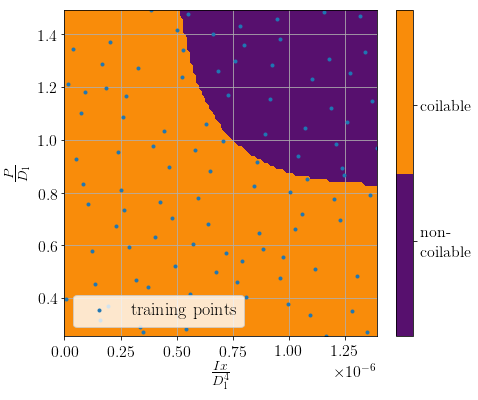

In [6]:
from QGP_metamaterial_postproc import plot_GP_classification_2d

Z = np.concatenate([Z_coiled, Z_failed])
Ix = np.concatenate([Ix_coiled, Ix_failed])
PD = np.concatenate([PD_coiled, PD_failed])

X_class = np.vstack([Ix, PD]).T
scaler_class = StandardScaler().fit(X_class)
X_class_scaled=scaler_class.transform(X_class)
x, y = np.meshgrid(np.linspace(0, max(Ix), 100), np.linspace(min(PD), max(PD), 100))
Xnew_class = np.vstack((x.ravel(), y.ravel())).T
Xnew_scaled_class=scaler_class.transform(Xnew_class)  

m_class = GPy.models.GPClassification(X_class_scaled, Z[:, None])

idx_not_classified, idx_classified = plot_GP_classification_2d(X_class, Xnew_scaled_class, m_class, 
                                                               x, y, xlab  = r'$\frac{Ix}{D_1^4}$', 
                                                               ylab = r'$\frac{P}{D_1}$', title = None, 
                                                               savepath = 'Figures/13_GP_classification.pdf')
                            #,savepath = '/home/gawel/thesis/chapter_4/figures/'  + 'Classification.pdf')
    
plt.grid(True)

## High fidelity GP regression

In [7]:
#training data
X1 = E_dict['{Ix}{D_1^4}']
X2 = E_dict['{P}{D_1}']
X = np.vstack([X1, X2]).T

Y = E_dict['P_crit']
Y1 = E_dict['E_abs']

#test points
x, y = np.meshgrid(np.linspace(0, max(X1), 100), np.linspace(min(X2), max(X2), 100))
Xnew = np.vstack((x.ravel(), y.ravel())).T

scaler = StandardScaler().fit(X)
X_scaled=scaler.transform(X)
Xnew_scaled=scaler.transform(Xnew) 

### Critical buckling load

In [8]:
 

kr = GPy.kern.Matern52(2, active_dims = [0, 1], name = 'matern')
np.random.seed(1)
m = GPy.models.GPRegression(X_scaled, Y[:, None], kr) # can be also on residual
m.optimize_restarts(3)
m

Optimization restart 1/3, f = 16.753218023882965
Optimization restart 2/3, f = 16.753217996161254
Optimization restart 3/3, f = 16.75321805154376


GP_regression.,value,constraints,priors
matern.variance,9361.871216764237,+ve,
matern.lengthscale,7.34866198625728,+ve,
Gaussian_noise.variance,5.562684646268137e-309,+ve,


GP prediction with noise


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label'
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'rasterized'



Name : GP regression
Objective : 16.753217996161254
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  matern.variance          |       9361.871216764237  |      +ve      |        
  matern.lengthscale       |        7.34866198625728  |      +ve      |        
  Gaussian_noise.variance  |  5.562684646268137e-309  |      +ve      |        


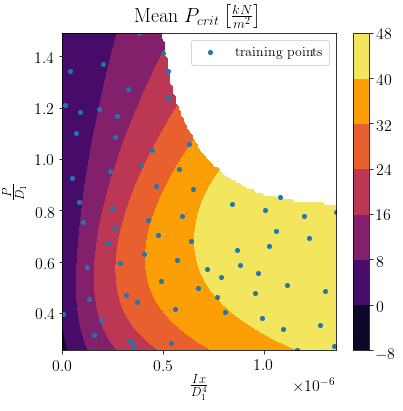

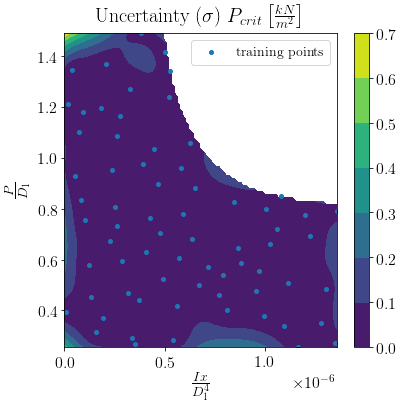

In [9]:
from QGP_metamaterial_postproc import plot_GP_2d

plot_GP_2d(X, Xnew_scaled, m, x, y, idx_class = idx_not_classified,
            xlab  = r'$\frac{Ix}{D_1^4}$', 
            ylab = r'$\frac{P}{D_1}$', 
            #title = '$P_{crit}$' , 
           #suptitle = 'Classical high-fidelity GP model: $P_{crit}\\left[\\frac{kN}{m^2}\\right]$' , 
           suptitle = '$P_{crit}\\left[\\frac{kN}{m^2}\\right]$', 
          split_plots = True)
          #savepath = '/home/gawel/presentation_figs/PNGs/P_hf_GP')
                  


### Absorbed energy

In [10]:
kr_e = GPy.kern.Matern52(2, active_dims = [0, 1], name = 'matern')
Eabs = E_dict['E_abs']
np.random.seed(1)
m_e = GPy.models.GPRegression(X_scaled, Eabs[:, None], kr) # can be also on residual
m_e.optimize_restarts(3)
m_e

Optimization restart 1/3, f = 134.8848091005903
Optimization restart 2/3, f = 127.73147610401887
Optimization restart 3/3, f = 140.14076381209156


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1


GP_regression.,value,constraints,priors
matern.variance,210.17246270290036,+ve,
matern.lengthscale,1.9079346509010815,+ve,
Gaussian_noise.variance,0.3311867410543881,+ve,


GP prediction with noise


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label'



Name : GP regression
Objective : 127.73147610401887
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  matern.variance          |  210.17246270290036  |      +ve      |        
  matern.lengthscale       |  1.9079346509010815  |      +ve      |        
  Gaussian_noise.variance  |  0.3311867410543881  |      +ve      |        


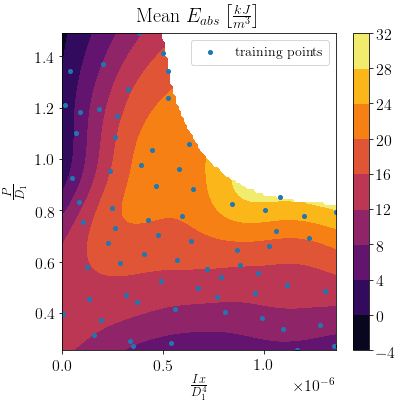

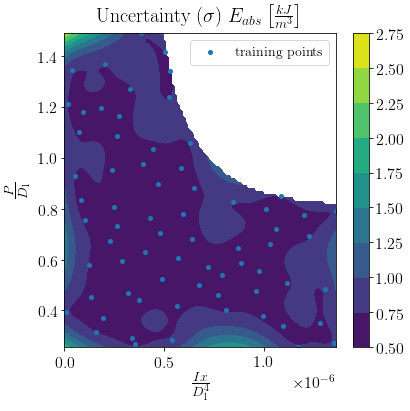

In [11]:
plot_GP_2d(X, Xnew_scaled, m_e, x, y, idx_class = idx_not_classified,
            xlab  = r'$\frac{Ix}{D_1^4}$', 
            ylab = r'$\frac{P}{D_1}$',  
           #suptitle = 'Classical high-fidelity GP model: $E_{abs}\\left[\\frac{kJ}{m^3}\\right]$')#,
           suptitle = ' $E_{abs}\\left[\\frac{kJ}{m^3}\\right]$', 
                     split_plots = True)
          
           #   savepath = '/home/gawel/thesis/chapter_4/figures/'  + '2d_Eabs-classical_GP.pdf')


# Old dataa

### Preparation 

GP prediction with noise


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label'
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'rasterized'



Name : GP regression
Objective : 28.81349026686881
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  Mat52.variance           |      753.9088843306378  |      +ve      |        
  Mat52.lengthscale        |     2.8347316593522405  |      +ve      |        
  Gaussian_noise.variance  |  9.931010744479322e-32  |      +ve      |        


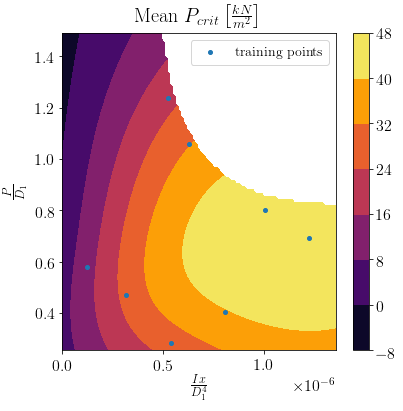

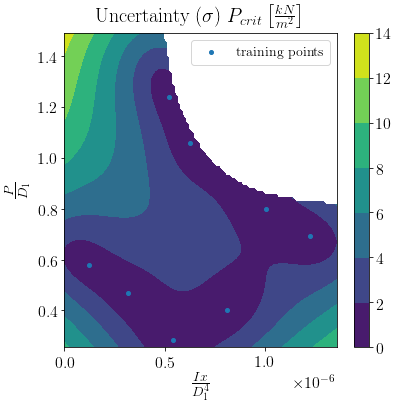

In [48]:
x, y = np.meshgrid(np.linspace(0, max(X1), 100), np.linspace(min(X2), max(X2), 100))


np.random.seed(2)
m8 = GPy.models.GPRegression(X_scaled[:8], Y[:8, None], GPy.kern.Matern52(2)) # can be also on residual
m8.optimize()

plot_GP_2d(X[:8], Xnew_scaled, m8, x, y, idx_class = idx_not_classified,
            xlab  = r'$\frac{Ix}{D_1^4}$', 
            ylab = r'$\frac{P}{D_1}$', 
          #suptitle = 'Classical reduced GP model: $P_{crit}\\left[\\frac{kN}{m^2}\\right]$'   
          #,savepath = '/home/gawel/thesis/chapter_4/figures/'  + '2d_Pcrit-reduced_GP.pdf'
           suptitle = '$P_{crit}\\left[\\frac{kN}{m^2}\\right]$', 
        split_plots = True, 
          #savepath = '/home/gawel/presentation_figs/PNGs/P_R_GP'
          )
#plt.grid(True)

#### System Eigenvalues 

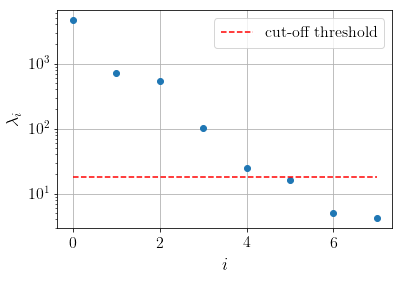

In [49]:
mat = m8.kern.K(X_scaled[:8], X_scaled[:8])
eigs = np.linalg.eigvals(mat)
plt.semilogy(eigs, 'o')


k = 8
threshold = np.max(eigs)/(2**k-1)
plt.semilogy(np.arange(len(eigs)),
             np.ones(len(eigs))*threshold, 
             '--r', label = 'cut-off threshold')
plt.ylabel('$\lambda_i$')
plt.xlabel('$i$')
plt.legend()
plt.grid(True)
plt.show()

#### Input dictionary

In [50]:
x, y = np.meshgrid(np.linspace(0, max(X1), 7), np.linspace(min(X2), max(X2), 7))
Xnew_test = np.vstack((x.ravel(), y.ravel())).T
Xnew_test_scaled = scaler.transform(Xnew_test)

U_list = []
for i in range(49):
    U_list.append(m8.kern.K(Xnew_test_scaled, X_scaled[:8])[i, :])

    
input_dictionary = {}
experiment_name = 'PD-Ix-100_8x8-49'
#dir_name = 'serial_experiment_2d/'


input_dictionary['experiment_name'] = experiment_name
input_dictionary['n'] = 8
input_dictionary['k'] = 8
input_dictionary['tslc'] = 40
input_dictionary['u_list'] = U_list

V = Y[:8]
input_dictionary['v_list'] = V
input_dictionary['matrix'] = mat
input_dictionary['Xnew'] = Xnew

#UNCOMMENT TO OVERWRITE
#f =open(experiment_name + '.pickle','wb')
#pickle.dump(input_dictionary, f)
#f.close()

### Postprocessing

#### Mean

/home/gawel/qgpr/serial_experiment_2d/PD-Ix-100_8x8-49/results/


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/numpy/ma/core.py:2788: ComplexWarning:Casting complex values to real discards the imaginary part


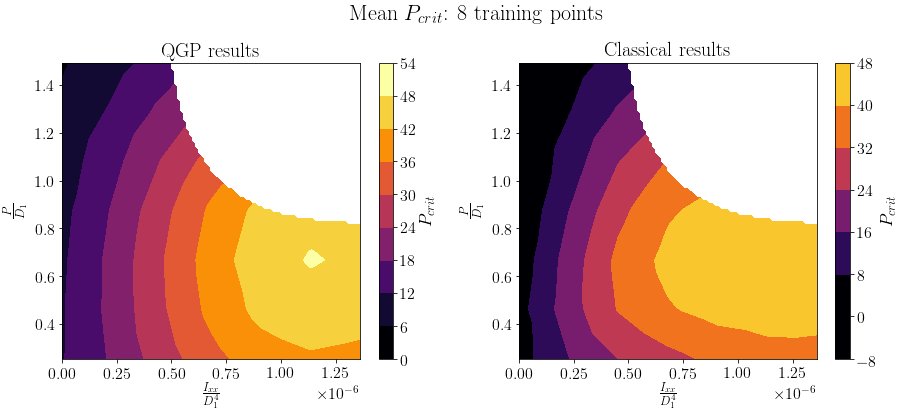

In [51]:
experiment_name = 'PD-Ix-100_8x8-49'
test_8x8_1 = postproc_QGP_2d(experiment_name, Xnew_test)
test_8x8_1.plot_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = 'Mean $P_{crit}$:  8 training points',
                        idx_class= (idx_not_classified[1],idx_not_classified[0])
                        )#,savepath = '/home/gawel/thesis/chapter_4/figures/'  + '2d_QGP_Pcrit.pdf')

#plt.grid(True)

[1.00e+02 4.93e+00 3.16e+00 1.06e+01 1.63e+01 6.17e-01 1.00e+02 3.68e+01
 5.08e+00 8.96e+00 3.03e+00 1.29e+01 2.40e+00 8.10e+00 1.51e+01 1.00e+02
 9.26e+00 5.56e+00 1.00e+02 1.98e+00 1.51e+01 1.22e+01 1.52e+01 1.45e+01
 1.55e+01 1.50e+01 5.95e+00 9.13e+00 1.27e+00 4.07e+00 2.61e+00 1.99e+01
 7.15e+00 1.91e+00 1.30e+01 1.00e+02 6.57e+00 1.00e+02 1.00e+02 4.11e+00
 3.31e+01 1.00e+02 1.69e+01 8.93e+00 6.98e+01 1.17e+01 9.83e-02 3.00e+00
 1.18e+01]
error capped to 100%


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:254: RuntimeWarning:invalid value encountered in greater
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:255: RuntimeWarning:invalid value encountered in less


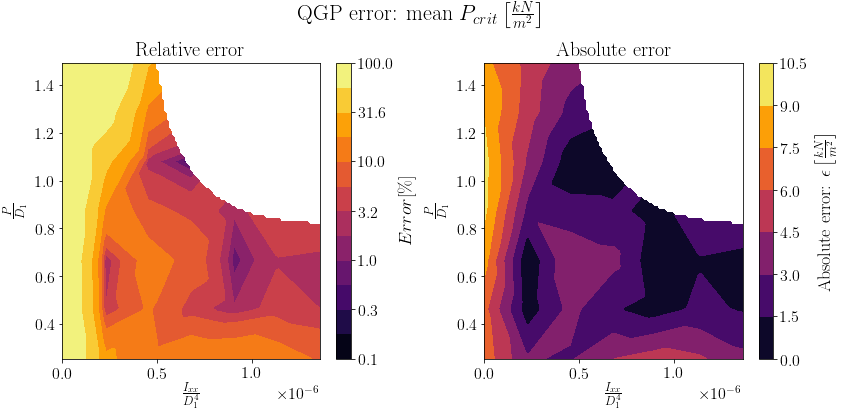

In [474]:
test_8x8_1.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = 'QGP error: mean $P_{crit} \\left[\\frac{kN}{m^2}\\right]$',vmax = 99,
                        idx_class= (idx_not_classified[1],idx_not_classified[0]), 
                        #savepath = '/home/gawel/thesis/chapter_4/figures/'  + 'QGP_Pcrit_error.pdf', 
                        zlabel2 = 'Absolute error: $\epsilon \\left[\\frac{kN}{m^2}\\right]$'
                        #savepath2 = '/home/gawel/thesis/chapter_4/figures/'  
                        #       + 'QGP_Pcrit_error_verification.pdf')
                        ) 


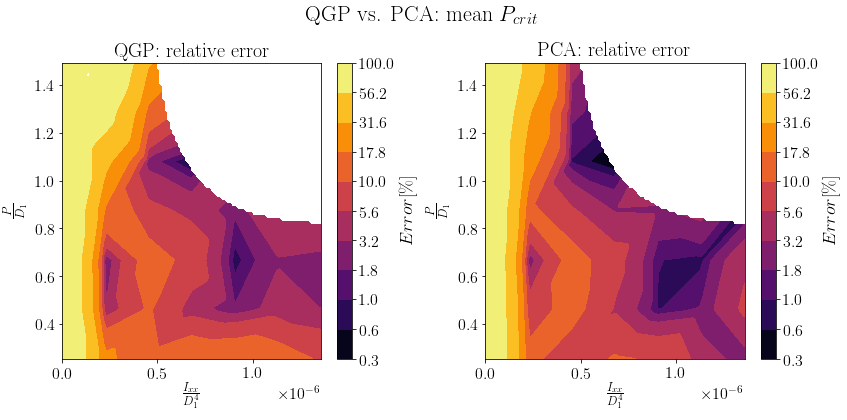

Saving figure!


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'rasterized'


(<Figure size 864x432 with 4 Axes>, <Figure size 864x432 with 2 Axes>)

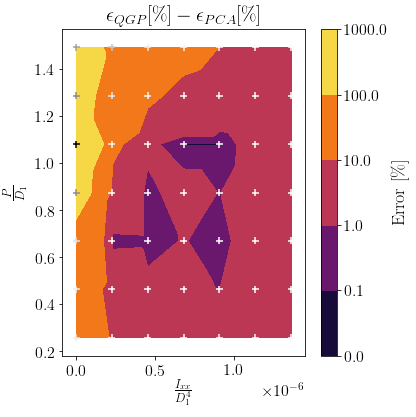

In [485]:
test_8x8_1.plot_verification_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                            CMAP = 'inferno', xlabel = '$\\frac{I_{xx}}{D_1^4}$',
                                      suptitle = 'QGP vs. PCA: mean $P_{crit}$ ', 
                      ylabel = '$\\frac{P}{D_1}$', zlabel = '$Error[\%]$'
                    ,idx_class=  (idx_not_classified[1],idx_not_classified[0]), #, 
                    savepath1 = '/home/gawel/thesis/appendix_f/figures/'+ 'QGP_Pcrit_error_verification.pdf')
                               

#### Uncertainty

/home/gawel/qgpr/serial_experiment_2d/PD-Ix-100_8x8-49/results-var/
NEGATIVE VARIANCE ENOUNTERED!!, value nulled


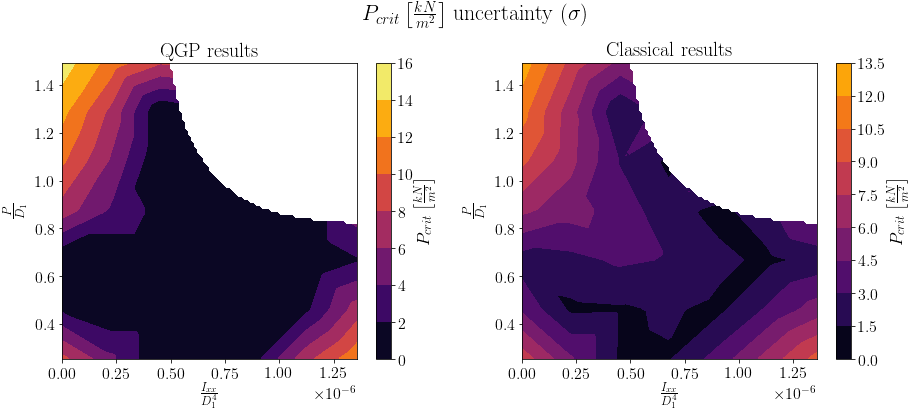

In [53]:
experiment_name = 'PD-Ix-100_8x8-49'
test_8x8_1_var = postproc_QGP_2d(experiment_name, Xnew_test, var_data = True, m = m8, 
                                 Xnew_test_scaled = Xnew_test_scaled)


#test_8x8_1_var._QGP_predict[0] = 0
#test_8x8_1_var._QGP_predict[2] = 0

test_8x8_1_var.plot_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = '$P_{crit}\\left[\\frac{kN}{m^2}\\right]$ uncertainty ($\sigma$)',
                             zlabel = '$P_{crit}\\left[\\frac{kN}{m^2}\\right]$', 
                        idx_class= (idx_not_classified[1],idx_not_classified[0]), vmin = -1e-2, vmax = 16)
                      #savepath = '/home/gawel/thesis/chapter_4/figures/'  + '2d_QGP_Pcrit.pdf')



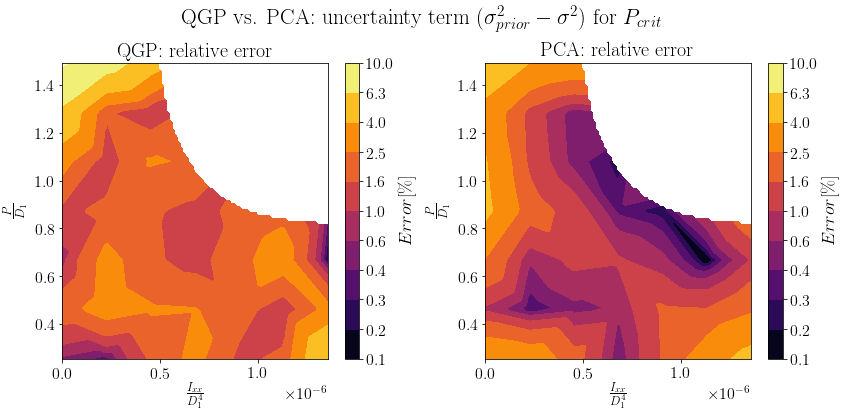

Saving figure!


(<Figure size 864x432 with 4 Axes>, <Figure size 864x432 with 2 Axes>)

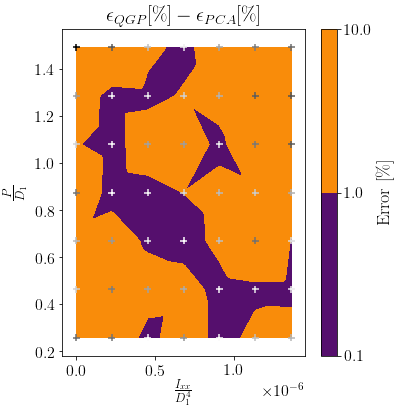

In [484]:
test_8x8_1_var.plot_verification_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                            CMAP = 'inferno', xlabel = '$\\frac{I_{xx}}{D_1^4}$', 
                    suptitle = 'QGP vs. PCA: uncertainty term ($\sigma^2_{prior} - \sigma^2)$ for $P_{crit}$', 
                      ylabel = '$\\frac{P}{D_1}$', zlabel = '$Error[\%]$',variance_case = True ,
                                          levels = np.logspace(-1, 1, 11), 
                    idx_class=  (idx_not_classified[1],idx_not_classified[0]), 
                    savepath1 = '/home/gawel/thesis/appendix_f/figures/'+ 'QGP_Pcrit_var_error_verification.pdf'
                                         )


[  2.75 100.    33.43 100.    28.13 100.    10.78  10.47  32.7    3.35
 100.   100.   100.   100.     4.97  62.14  20.78   5.74  31.44 100.
   4.34   5.01 100.     6.43  51.86 100.   100.     4.69 100.    46.61
   8.72   5.48  61.4  100.    13.57  11.87  66.05  13.87 100.   100.
  48.02  17.29  16.57   1.19  13.08   3.78 100.   100.   100.  ]
error capped to 100%


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:254: RuntimeWarning:invalid value encountered in greater
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:255: RuntimeWarning:invalid value encountered in less
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'rasterized'


Saving figure!


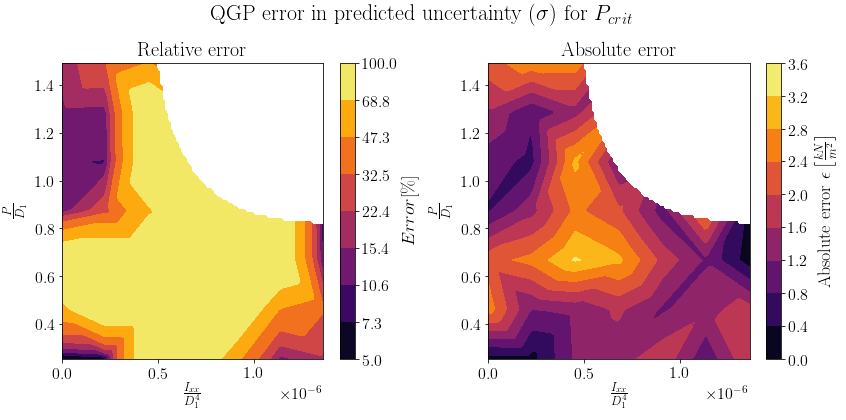

In [499]:
test_8x8_1_var.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = 'QGP error in predicted uncertainty ($\sigma$) for $P_{crit}$',
                                   vmax = 10,levels = np.logspace(0.7, 2, 9), 
                                   zlabel2 = 'Absolute error $\epsilon \\left[\\frac{kN}{m^2}\\right]$',
                        idx_class= (idx_not_classified[1],idx_not_classified[0]), 
                        savepath = '/home/gawel/thesis/appendix_f/figures/'  + 'QGP_Pcrit_uncertainty_error.pdf', 
                                  variance_case = True)

#### Combined 

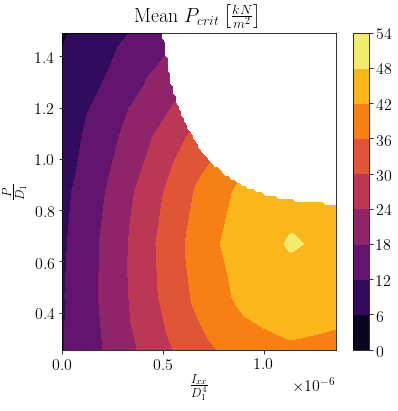

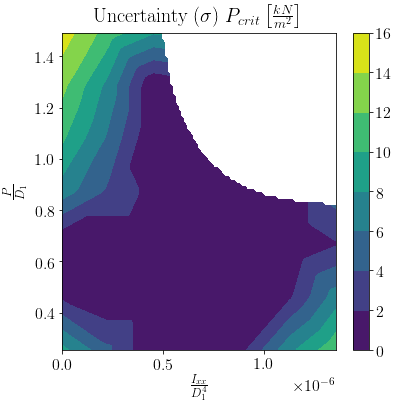

In [59]:
qgp_mean = test_8x8_1._QGP_predict
points_mean = test_8x8_1._xqgp

qgp_std = test_8x8_1_var._QGP_predict
points_std = test_8x8_1_var._xqgp 

combined_qgp_plot(qgp_mean, points_mean, qgp_std, points_std, 
                 split_plots = True, 
                 savepath = '/home/gawel/presentation_figs/PNGs/P-QGP', 
                 title = '$P_{crit} \\left[\\frac{kN}{m^2}\\right]$')
                  #title = 'QGP model: $P_{crit} \\left[\\frac{kN}{m^2}\\right]$', 
                  #savepath = '/home/gawel/thesis/chapter_4/figures/'  + 'Pcrit_QGP_2d.pdf')



## Sensitivity to the training point selection

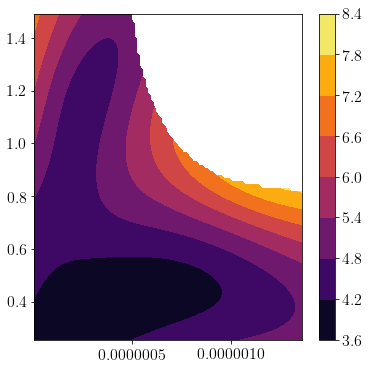

In [31]:
x, y = np.meshgrid(np.linspace(min(X1), max(X1), 100), np.linspace(min(X2), max(X2), 100))

n_sample_systems = 100
Means_array = []

X_scaled[:8], Y[:8, None]

for i in range(n_sample_systems):
    np.random.seed(i)
    test_set =  np.random.choice(len(X_scaled), 8)
    np.random.seed(i)
    m8_test = GPy.models.GPRegression(X_scaled[test_set], Y[test_set, None], GPy.kern.Matern52(2)) # can be also on residual
    m8_test.optimize()
    
    
    mean, Cov = m8_test.predict(Xnew_scaled, full_cov=False) 
    mean_mat = mean.reshape(x.shape)
    mean_mat[idx_not_classified] = np.nan
    Means_array.append(mean_mat)
    
    '''
    plot_GP_2d(X[test_set], Xnew_scaled, m8_test, x, y, idx_class = idx_not_classified,
                xlab  = r'$\frac{Ix}{D_1^4}$', 
                ylab = r'$\frac{P}{D_1}$', 
                suptitle = '$P_{crit}$: reduced classical GP model, test:' +str(i) )
               #,savepath = '/home/gawel/thesis/chapter_4/figures/'  + 'Eabs_8pts-classical_GP.pdf')
    plt.show()
    '''
    
stats = np.array(Means_array)
stds_Pcrit = np.std(stats, axis = 0)


fig = plt.figure(figsize=(6, 6))
plt.subplot(1,1,1)
plt.contourf(x, y,stds  , cmap = 'inferno', label = "STD in estimation between prediction of 5 moels with random")
plt.colorbar()
#plt.plot(X[:,0],X[:,1],'.', markersize = 8, label = 'training points'), #plt.axis("square")


## PD-Ix-100-8x8 E_abs  [FAULTY !!!!]

this dataset used wrong input matrix, results are rubbish


GP prediction with noise


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label'


Saving figure!

Name : GP regression
Objective : 25.722062076422
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  Mat52.variance           |  221.11393669430794  |      +ve      |        
  Mat52.lengthscale        |    2.58262435128989  |      +ve      |        
  Gaussian_noise.variance  |  1.9953224970285457  |      +ve      |        


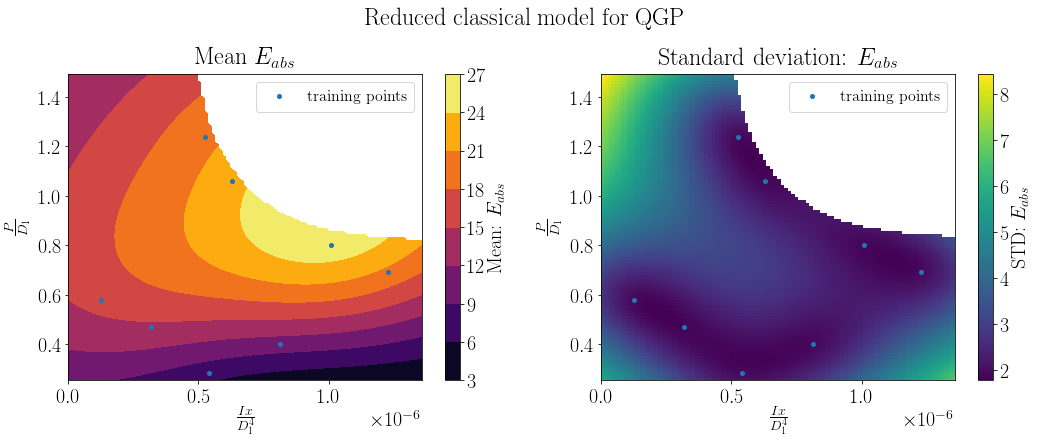

In [115]:
x, y = np.meshgrid(np.linspace(0, max(X1), 100), np.linspace(min(X2), max(X2), 100))


np.random.seed(2)
m8_e = GPy.models.GPRegression(X_scaled[:8], Eabs[:8, None], GPy.kern.Matern52(2)) # can be also on residual
m8_e.optimize()

plot_GP_2d(X[:8], Xnew_scaled, m8_e, x, y, idx_class = idx_not_classified,
            xlab  = r'$\frac{Ix}{D_1^4}$', 
            ylab = r'$\frac{P}{D_1}$', 
            title = '$E_{abs}$', 
           suptitle = 'Reduced classical model for QGP'
           ,savepath = '/home/gawel/thesis/chapter_4/figures/'  + 'Eabs_8pts-classical_GP.pdf'
          )

### Preparation

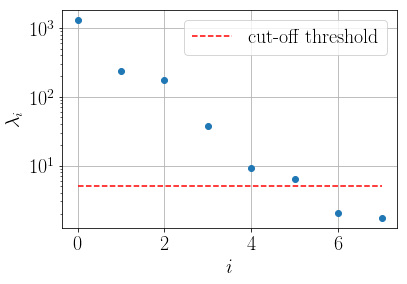

In [928]:
mate = m8_e.kern.K(X_scaled[:8], X_scaled[:8])
eigs = np.linalg.eigvals(mate)
plt.semilogy(eigs, 'o')


k = 8
threshold = np.max(eigs)/(2**k-1)
plt.semilogy(np.arange(len(eigs)),
             np.ones(len(eigs))*threshold, 
             '--r', label = 'cut-off threshold')
plt.ylabel('$\lambda_i$')
plt.xlabel('$i$')
plt.legend()
plt.grid(True)
plt.show()

In [940]:
x, y = np.meshgrid(np.linspace(0, max(X1), 7), np.linspace(min(X2), max(X2), 7))
Xnew_test = np.vstack((x.ravel(), y.ravel())).T
Xnew_test_scaled = scaler.transform(Xnew_test)

U_list = []
for i in range(49):
    U_list.append(m8_e.kern.K(Xnew_test_scaled, X_scaled[:8])[i, :])

    
input_dictionary = {}
experiment_name = 'PD-Ix-100_8x8-49-E'
#dir_name = 'serial_experiment_2d/'


input_dictionary['experiment_name'] = experiment_name
input_dictionary['n'] = 8
input_dictionary['k'] = 8
input_dictionary['tslc'] = 40
input_dictionary['u_list'] = U_list

V = Y[:8]
input_dictionary['v_list'] = V
input_dictionary['matrix'] = mat
input_dictionary['Xnew'] = Xnew

#UNCOMMENT TO OVERWRITE
#f =open(experiment_name + '.pickle','wb')
#pickle.dump(input_dictionary, f)
#f.close()

In [942]:
for u in U_list:
    print(u@np.linalg.solve(mat, u)'\t')
    
    

58.63387200667116
63.75542510705021
65.60837558668618
65.45200788041977
64.7418335767407
61.55149256536194
56.74333206349384
64.06735191605758
65.63011853558433
65.34254499188417
65.09793330293358
65.5461712616093
64.31667172491902
63.04589882251493
65.2741067587343
64.42950585793619
64.07895168203801
64.45794677360979
65.04178714477436
65.06002881976444
65.50593440657099
60.86170135081339
61.71404588105286
63.598593037151765
65.21223848779749
65.81557068911242
65.25257742021589
63.16244904514275
55.387155368663265
60.10388368475989
64.313746734254
65.70390341593605
63.76718673579119
60.55349266166683
55.60833298553026
52.31209243437413
60.65691572593286
65.32386849735187
63.856344535744014
58.35167992230686
51.87171503761098
44.94812705503033
48.95193388587066
58.95701068989963
63.36238761002659
59.76548991263071
51.38306936885823
42.438584217596606
34.38056111196472


### Postprocessing

#### Mean

/home/gawel/qgpr/serial_experiment_2d/PD-Ix-100_8x8-49-E/results/


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/numpy/ma/core.py:2788: ComplexWarning:Casting complex values to real discards the imaginary part
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/numpy/core/numeric.py:591: ComplexWarning:Casting complex values to real discards the imaginary part


Saving figure!


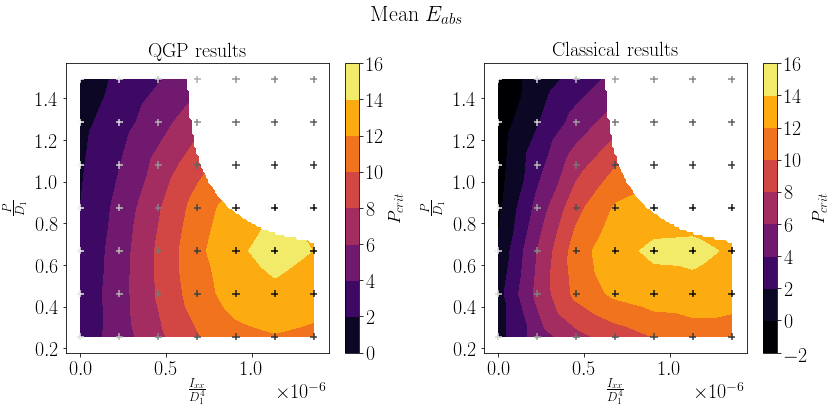

In [162]:
experiment_name = 'PD-Ix-100_8x8-49-E'
test_8x8_1E = postproc_QGP_2d(experiment_name, Xnew_test)
test_8x8_1E.plot_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = 'Mean $E_{abs}$',
                        idx_class= idx_not_classified, 
                          vmin = 0, vmax = 16, 
                      #savepath = '/home/gawel/thesis/chapter_4/figures/'  + '2d_QGP_E_abs.pdf')



[100.    11.45   0.38  22.09   1.1    4.04 100.    23.19   3.46   8.66
  21.37  24.26   7.73  15.16  19.15  99.58   6.19   5.94 100.     0.28
  19.9   15.5   10.45  17.01  12.63   8.64   6.15  11.15  16.98   1.17
   1.13   1.66   3.56   2.35  10.34 100.    17.66 100.   100.    11.32
  36.22 100.    18.08  10.23  72.    13.97   5.78   1.43   2.01]
error capped to 100%


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:221: RuntimeWarning:invalid value encountered in greater
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'rasterized'


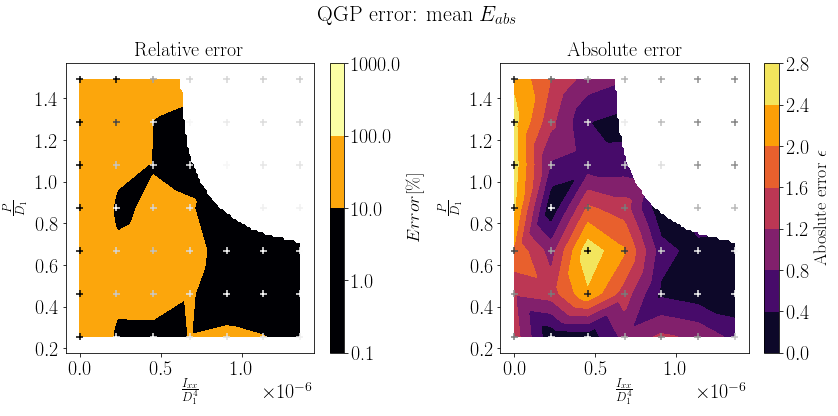

In [163]:
test_8x8_1E.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = 'QGP error: mean $E_{abs}$',
                        idx_class= idx_not_classified)
                        #,savepath = '/home/gawel/thesis/appendix_f/figures/'  + 'QGP_Eabs_error.pdf')
                        #savepath2 = '/home/gawel/thesis/chapter_4/figures/'  
                        #       + 'QGP_Pcrit_error_verification.pdf')


## Dataset PD-Ix-100_8x8-49 tslc 50

In [883]:
x, y = np.meshgrid(np.linspace(0, max(X1), 7), np.linspace(min(X2), max(X2), 7))
Xnew_test = np.vstack((x.ravel(), y.ravel())).T
Xnew_test_scaled = scaler.transform(Xnew_test)

U_list = []
for i in range(49):
    U_list.append(m8.kern.K(Xnew_test_scaled, X_scaled[:8])[i, :])

    
input_dictionary = {}
experiment_name = 'PD-Ix-100_8x8-49-tslc-50'
#dir_name = 'serial_experiment_2d/'


input_dictionary['experiment_name'] = experiment_name
input_dictionary['n'] = 8
input_dictionary['k'] = 8
input_dictionary['tslc'] = 50
input_dictionary['u_list'] = U_list

V = Y[:8]
input_dictionary['v_list'] = V
input_dictionary['matrix'] = mat
input_dictionary['Xnew'] = Xnew

#UNCOMMENT TO OVERWRITE
#f =open(experiment_name + '.pickle','wb')
#pickle.dump(input_dictionary, f)
#f.close()

### Postprocessing

/home/gawel/qgpr/serial_experiment_2d/PD-Ix-100_8x8-49-tslc-50/results/


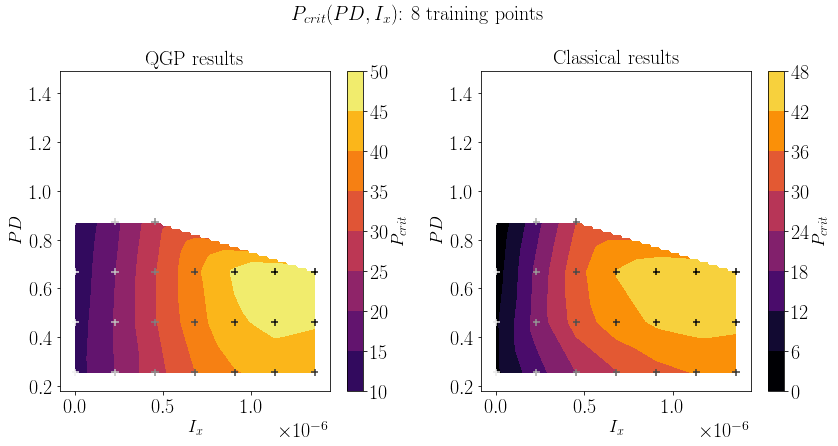

In [674]:
test_8x8_2 = postproc_QGP_2d(experiment_name, Xnew_test)
test_8x8_2.plot_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = '$P_{crit} (PD, I_x)$:  8 training points',
                        idx_class= idx_not_classified)



[100.     4.78   8.77  17.31   0.1    0.5   12.38   7.85 100.    10.87
  18.09  17.13   2.65   5.06   4.61  28.09   2.55  14.34 100.     6.21
 100.     3.16   4.22  16.74]
error capped to 100%


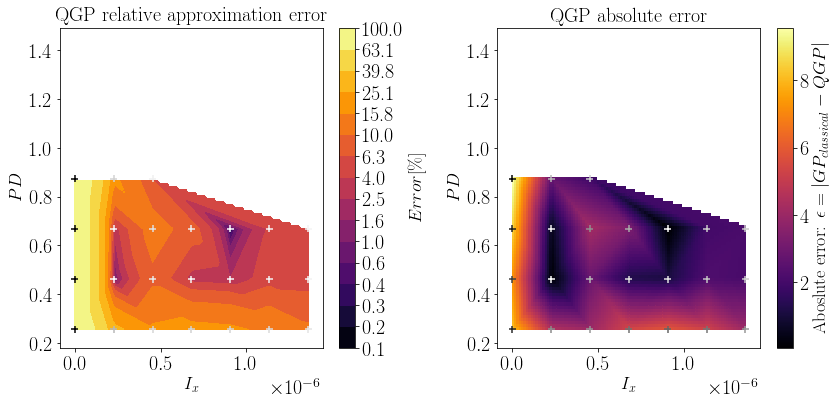

In [675]:
test_8x8_2.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = '$P_{crit} (PD, I_x)$:  8 training points',
                        idx_class= idx_not_classified)


[1.00e+02 4.78e+00 8.77e+00 1.73e+01 9.61e-02 4.98e-01 1.24e+01 7.85e+00
 1.00e+02 1.09e+01 1.81e+01 1.71e+01 2.65e+00 5.06e+00 4.61e+00 2.81e+01
 2.55e+00 1.43e+01 1.00e+02 6.21e+00 1.00e+02 3.16e+00 4.22e+00 1.67e+01]
error capped to 100%


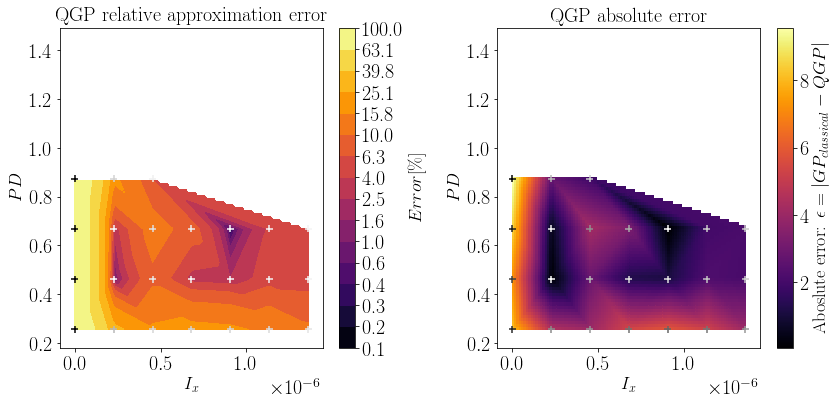

In [906]:
test_8x8_2.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = '$P_{crit} (PD, I_x)$:  8 training points',
                        idx_class= idx_not_classified)


### Conclusion:

no significant improvement in accuracy, so I go back to 20 tslc

### How much of it is due to low rank?

Coparison with classical PCA

[1.00e+02 4.93e+00 3.16e+00 1.06e+01 1.63e+01 6.17e-01 1.00e+02 3.68e+01
 5.08e+00 8.96e+00 3.03e+00 1.29e+01 2.40e+00 8.10e+00 1.51e+01 1.00e+02
 9.26e+00 5.56e+00 1.00e+02 1.98e+00 1.51e+01 1.22e+01 1.52e+01 1.45e+01
 1.55e+01 1.50e+01 5.95e+00 9.13e+00 1.27e+00 4.07e+00 2.61e+00 1.99e+01
 7.15e+00 1.91e+00 1.30e+01 1.00e+02 6.57e+00 1.00e+02 1.00e+02 4.11e+00
 3.31e+01 1.00e+02 1.69e+01 8.93e+00 6.98e+01 1.17e+01 9.83e-02 3.00e+00
 1.18e+01]
error capped to 100%


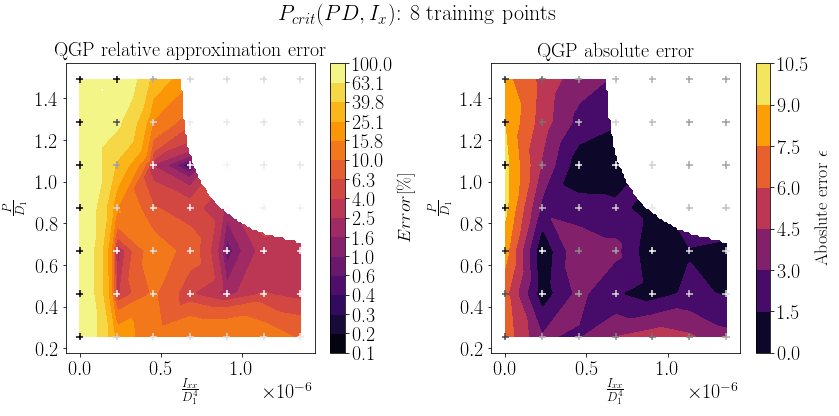

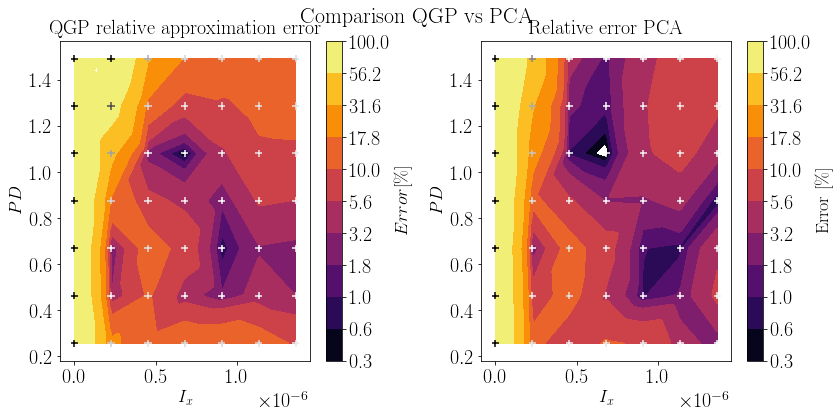

(<Figure size 864x432 with 4 Axes>, <Figure size 864x432 with 2 Axes>)

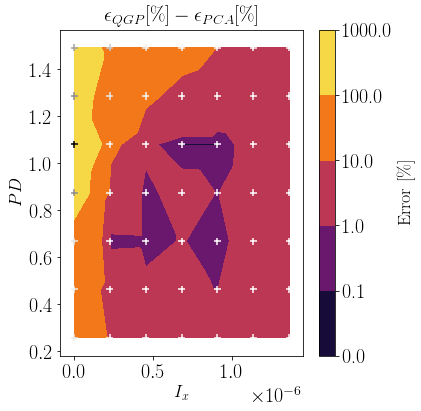

In [142]:
test_8x8_1.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = '$P_{crit} (PD, I_x)$:  8 training points',
                        idx_class= idx_not_classified)

test_8x8_1.plot_verification_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                            CMAP = 'inferno', xlabel = '$I_x$', suptitle = 'Comparison QGP vs PCA', 
                      ylabel = '$PD$', zlabel = '$Error[\%]$')

In [456]:
# in diagonal form:
#mu @ np.diag(eig) @ mu.T

5.108035305818607
[4.63e+03 7.14e+02 5.33e+02 1.01e+02 2.45e+01 1.59e+01 5.01e+00 4.22e+00]
[2.16e-04 1.40e-03 1.88e-03 9.88e-03 4.08e-02 6.29e-02 2.00e-01 2.37e-01]
(array([6, 7]),)
[0.   0.   0.   0.01 0.04 0.06 0.   0.  ]


In [458]:
print(mat_pca_inv)

[[ 0.01 -0.    0.   -0.   -0.01 -0.01  0.    0.01]
 [-0.    0.03  0.01 -0.01 -0.01  0.   -0.02 -0.01]
 [ 0.    0.01  0.01 -0.   -0.   -0.   -0.01  0.  ]
 [-0.   -0.01 -0.    0.01  0.    0.    0.01 -0.  ]
 [-0.01 -0.01 -0.    0.    0.01  0.01  0.   -0.01]
 [-0.01  0.   -0.    0.    0.01  0.01 -0.   -0.01]
 [ 0.   -0.02 -0.01  0.01  0.   -0.    0.02  0.01]
 [ 0.01 -0.01  0.   -0.   -0.01 -0.01  0.01  0.01]]


# QGP 8x8 systems PD-Ix-100-100 dataset

2nd iteration (final)

changes in respect to the 1st iteration:
- smarter sampling - only classified region
- Ix starting from min(Ix), not from 0
- better training point selection for Eabs

## Eabs

### Classical reduced GP model

Classical GP model trained on the QGP training set (8 points) used later for reference.

GP prediction with noise

Name : GP regression
Objective : 26.56572511999238
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  Mat52.variance           |      196.98092890117053  |      +ve      |        
  Mat52.lengthscale        |      1.9721484486626628  |      +ve      |        
  Gaussian_noise.variance  |  1.7525797289059906e-05  |      +ve      |        


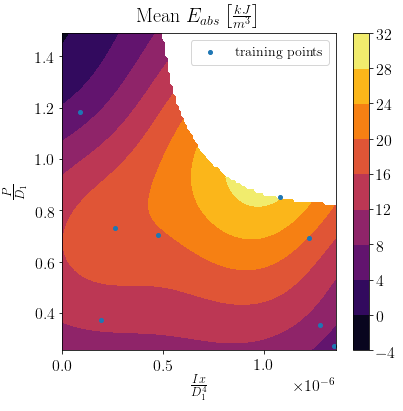

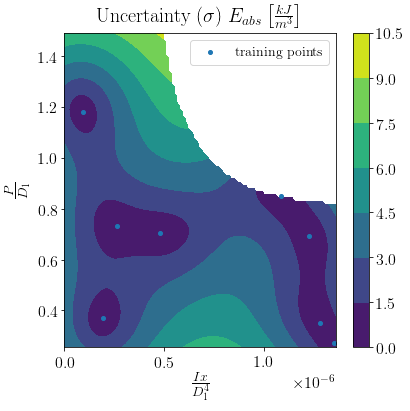

In [12]:
x, y = np.meshgrid(np.linspace(0, max(X1), 100), np.linspace(min(X2), max(X2), 100))

np.random.seed(2)
test_set =  np.random.choice(len(X_scaled), 8)

np.random.seed(2)
m8_e = GPy.models.GPRegression(X_scaled[test_set], Eabs[test_set, None], GPy.kern.Matern52(2)) # can be also on residual
m8_e.optimize()



plot_GP_2d(X[test_set], Xnew_scaled, m8_e, x, y, idx_class = idx_not_classified,
            xlab  = r'$\frac{Ix}{D_1^4}$', 
            ylab = r'$\frac{P}{D_1}$', 
            #suptitle = 'Classical reduced GP model: $E_{abs}\\left[\\frac{kJ}{m^3}\\right]$' )
           #,savepath = '/home/gawel/thesis/chapter_4/figures/'  + 'Eabs_8pts-classical_GP.pdf')
               suptitle = '$E_{abs}\\left[\\frac{kJ}{m^3}\\right]$', 
        split_plots = True 
          #savepath = '/home/gawel/presentation_figs/PNGs/E_R_GP'
          )
          

In [13]:
#m_class.predict(scaler_class.transform(Xnew_test))

### Input dictionary

Preparation of input data for QGP. 

In [14]:
approximate_num_of_samples = 100
hj = np.round(np.sqrt(100/0.8))

x, y = np.meshgrid(np.linspace(0, max(X1), hj), np.linspace(min(X2), max(X2), hj))
Xnew_test = np.vstack((x.ravel(), y.ravel())).T
Z_new_test = m_class.predict(scaler_class.transform(Xnew_test))
Xnew_test_classified = Xnew_test[np.where(Z_new_test[0]>0.5)[0], :]
Xnew_test_additional = Xnew_test[list(set(np.where(Z_new_test[0]<0.5)[0]) - set(np.where(Z_new_test[0]<0.2)[0]))]

Xnew_test_classified  = np.vstack((Xnew_test_classified , Xnew_test_additional ))

Xnew_test_scaled = scaler.transform(Xnew_test_classified)



U_list = []
for i in range(len(Xnew_test_scaled )):
    U_list.append(m8_e.kern.K(Xnew_test_scaled, X_scaled[test_set])[i, :])
 

    
input_dictionary = {}
experiment_name = 'PD-Ix-100-100-Eabs'
#dir_name = 'serial_experiment_2d/'


input_dictionary['experiment_name'] = experiment_name
input_dictionary['n'] = 8
input_dictionary['k'] = 8
input_dictionary['tslc'] = 40
input_dictionary['u_list'] = U_list

V = Eabs[test_set]
input_dictionary['v_list'] = V
input_dictionary['matrix'] = m8_e.kern.K(X_scaled[test_set], X_scaled[test_set])
input_dictionary['Xnew'] = Xnew_test_classified

#UNCOMMENT TO OVERWRITE
#f =open(experiment_name + '.pickle','wb')
#pickle.dump(input_dictionary, f)
#f.close()

#### Validating input dictionary

[ 9.89195253 10.33026847 10.52479301 10.63178615 10.81237442 11.09678134
 11.29952555 11.08085429 10.10204034  8.19240931  5.5785583  12.26324599
 12.93770507 13.1912026  13.25965431 13.4696259  13.94381578 14.4217493
 14.40968133 13.4763448  11.45386877  8.54552573 14.44130039 15.48782436
 15.87601621 15.9095334  16.17934068 16.94004604 17.77227249 17.91767643
 16.81211466 14.43488456 11.25524547 15.77865065 17.31773416 18.02366285
 18.19399109 18.72551684 20.00987367 21.41022099 21.85437527 20.56883385
 17.69217835 14.11516685 15.56921404 17.57988689 18.84492015 19.5922447
 20.78663371 22.8362019  25.00489517 26.03895933 24.92066947 21.71983302
 17.62051561 13.54164902 15.83921952 17.7860933  19.55711576 21.77214915
 24.65739924 27.54519697 29.22212102 10.17176497 12.57795745 15.15246421
 17.94038287 21.14094903 24.70728385  6.40782087  8.78105987 11.75115223
 15.20203151 19.01257859  3.17273093  5.40292579  8.43565757 12.0665675
 16.00424989  0.91301506  2.92144223  5.72704434  9.12

 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label'
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'rasterized'


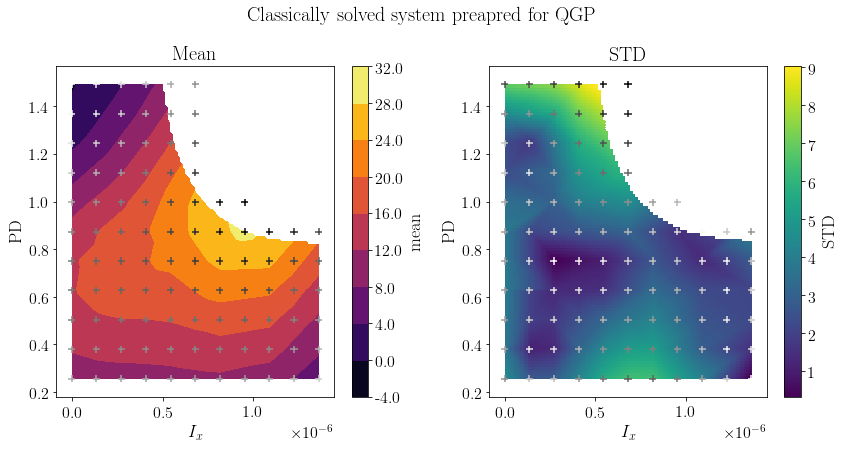

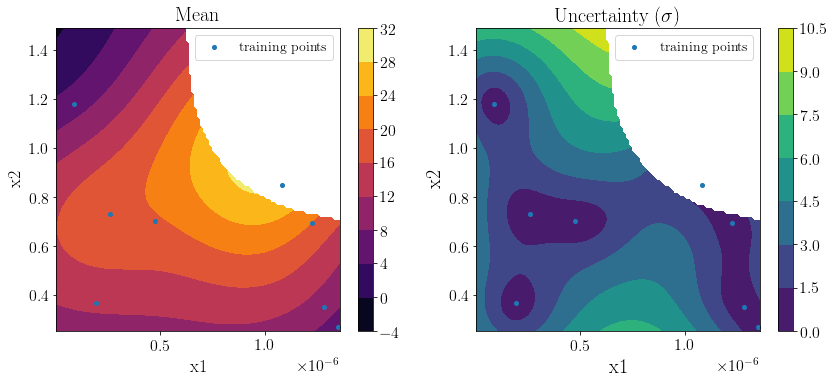

In [15]:
from QGP_metamaterial_postproc import dict_validation_plot

x_full, y_full = np.meshgrid(np.linspace(min(X1), max(X1), 100), np.linspace(min(X2), max(X2), 100))

dict_validation_plot(input_dictionary, [min(X1), max(X1), min(X2), max(X2)],
                     m8_e,  X[test_set], Xnew_scaled, x_full, y_full, 
                     idx_class = (idx_not_classified[1],idx_not_classified[0]) )



## QGP model 

/home/gawel/qgpr/serial_experiment_2d/PD-Ix-100-100-Eabs/results/


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/numpy/ma/core.py:2788: ComplexWarning:Casting complex values to real discards the imaginary part


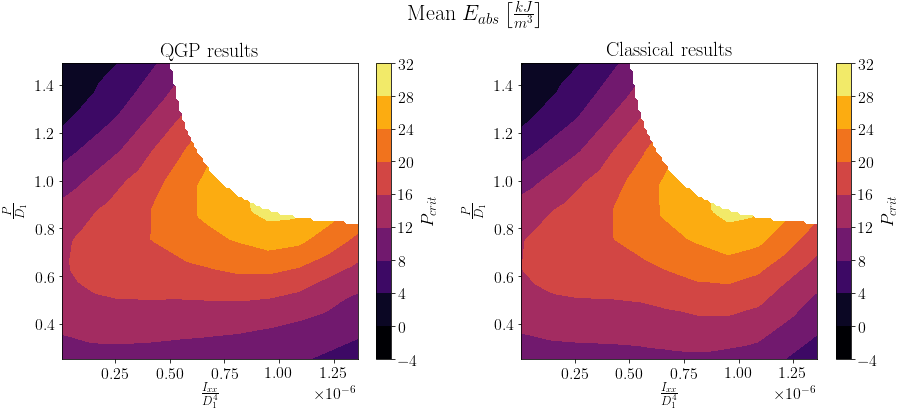

In [16]:
from QGP_metamaterial_postproc import postproc_QGP_2d

experiment_name = 'PD-Ix-100-100-Eabs'
test_E_mean = postproc_QGP_2d(experiment_name, Xnew_test_classified)
test_E_mean.plot_countour(xbounds = [min(X1), max(X1), min(X2), max(X2)],
                         suptitle = 'Mean $E_{abs}\\left[\\frac{kJ}{m^3}\\right]$',
                        idx_class= (idx_not_classified[1],idx_not_classified[0])
                          , vmin = 0, vmax = 32, plot_query_points = False)
                         
                         #,savepath = '/home/gawel/thesis/chapter_4/figures/'  + '2d_QGP_Pcrit.pdf')



/home/gawel/qgpr/serial_experiment_2d/PD-Ix-100-100-Eabs/results-var/
NEGATIVE VARIANCE ENOUNTERED!!, value nulled


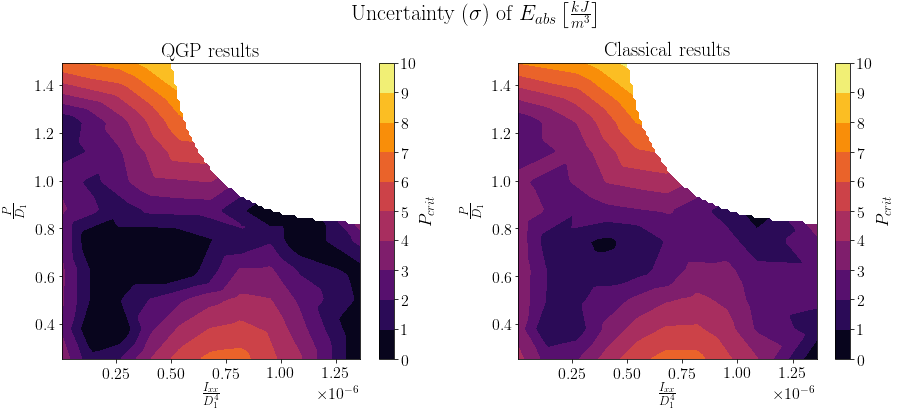

In [17]:
experiment_name = 'PD-Ix-100-100-Eabs'
test_E_var = postproc_QGP_2d(experiment_name, Xnew_test_classified, var_data = True, m = m8_e, 
                                 Xnew_test_scaled = Xnew_test_scaled)


#test_8x8_1_var._QGP_predict[0] = 0
#test_8x8_1_var._QGP_predict[2] = 0

test_E_var.plot_countour(xbounds = [min(X1), max(X1), min(X2), max(X2)],
                         suptitle = 'Uncertainty ($\sigma$) of $E_{abs} \\left[\\frac{kJ}{m^3}\\right]$',
                        idx_class=  (idx_not_classified[1],idx_not_classified[0]), 
                        vmin = -1e-2, vmax = 10, levels = np.linspace(0, 10, 11)) #, zlabel = '$E_{abs}$'
                        #,savepath = '/home/gawel/thesis/appendix_f/figures/'  + '2d_QGP_Pcrit.pdf', zlabel = None)


[2.66098481e+00 6.61266354e+01 5.41873331e-01 1.03876612e+00
 2.37039103e+00 7.19047495e+00 1.21863062e+00 1.06996460e+00
 5.77673747e-01 1.75214035e+01 8.92708148e+00 9.43172655e-01
 8.08438721e+00 2.45009265e-01 1.16865346e+01 7.74875442e-01
 4.05359071e+00 1.74077280e+01 1.32552679e+00 8.99499082e+00
 1.24563630e+01 1.39008945e+01 7.56593247e+00 4.41418415e+00
 1.30774913e+00 3.96536666e+00 9.25047926e-01 1.90093158e+01
 9.86764036e-01 1.62976350e+01 1.93021019e+01 1.35473408e+00
 1.66182687e+00 5.14298191e+00 4.84433252e+00 1.98326565e+00
 3.76745181e-01 3.74341398e+00 5.10708251e-01 3.32310096e-01
 1.57606177e+00 3.73347469e+00 4.84425587e+00 2.75338573e+00
 1.31318882e+00 3.62728911e-01 1.75561931e+01 5.91060157e+00
 5.46603567e-01 1.59005159e+00 1.46908077e+00 1.71348828e+00
 4.11519192e+00 1.46361003e+00 1.22342809e+00 1.43862840e+01
 2.69024428e+00 7.17932327e+00 1.47405199e+00 2.95790314e+00
 1.64794785e+00 3.65953909e-01 8.20284963e-02 6.59678579e-01
 1.13940771e+01 1.133696

 /home/gawel/Desktop/QGP_paper_code/QGP_metamaterial_postproc.py:743: RuntimeWarning:invalid value encountered in greater
 /home/gawel/Desktop/QGP_paper_code/QGP_metamaterial_postproc.py:744: RuntimeWarning:invalid value encountered in less
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'rasterized'


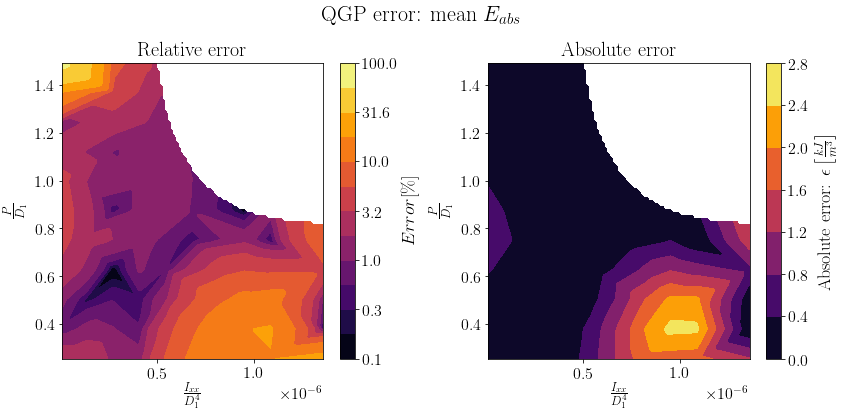

In [18]:
test_E_mean.plot_error_countour(xbounds = [min(X1), max(X1), min(X2), max(X2)],
                         suptitle = 'QGP error: mean $E_{abs}$',
                        idx_class= (idx_not_classified[1],idx_not_classified[0]), 
                                zlabel2 = 'Absolute error: $\epsilon \\left[\\frac{kJ}{m^3}\\right]$')
                                #, savepath = '/home/gawel/thesis/chapter_4/figures/'+ 'QGP_Eabs_error.pdf')
                    
                        #savepath2 = '/home/gawel/thesis/chapter_4/figures/'  
                        #       + 'QGP_Pcrit_error_verification.pdf')


[2.66098481e+00 6.61266354e+01 5.41873331e-01 1.03876612e+00
 2.37039103e+00 7.19047495e+00 1.21863062e+00 1.06996460e+00
 5.77673747e-01 1.75214035e+01 8.92708148e+00 9.43172655e-01
 8.08438721e+00 2.45009265e-01 1.16865346e+01 7.74875442e-01
 4.05359071e+00 1.74077280e+01 1.32552679e+00 8.99499082e+00
 1.24563630e+01 1.39008945e+01 7.56593247e+00 4.41418415e+00
 1.30774913e+00 3.96536666e+00 9.25047926e-01 1.90093158e+01
 9.86764036e-01 1.62976350e+01 1.93021019e+01 1.35473408e+00
 1.66182687e+00 5.14298191e+00 4.84433252e+00 1.98326565e+00
 3.76745181e-01 3.74341398e+00 5.10708251e-01 3.32310096e-01
 1.57606177e+00 3.73347469e+00 4.84425587e+00 2.75338573e+00
 1.31318882e+00 3.62728911e-01 1.75561931e+01 5.91060157e+00
 5.46603567e-01 1.59005159e+00 1.46908077e+00 1.71348828e+00
 4.11519192e+00 1.46361003e+00 1.22342809e+00 1.43862840e+01
 2.69024428e+00 7.17932327e+00 1.47405199e+00 2.95790314e+00
 1.64794785e+00 3.65953909e-01 8.20284963e-02 6.59678579e-01
 1.13940771e+01 1.133696

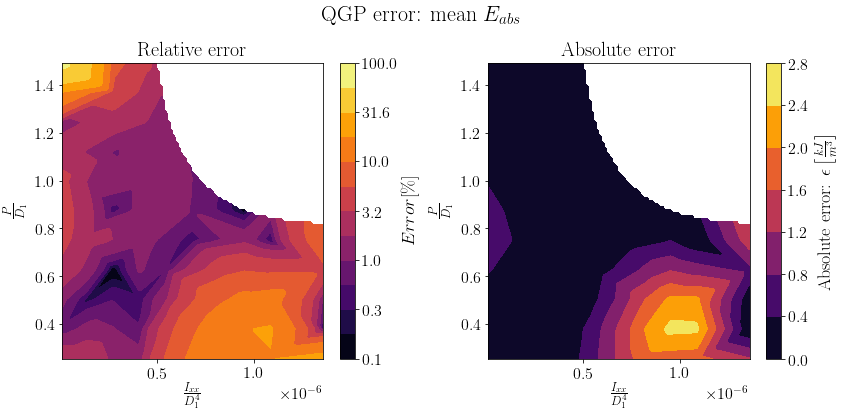

In [19]:
test_E_mean.plot_error_countour(xbounds = [min(X1), max(X1), min(X2), max(X2)],
                         suptitle = 'QGP error: mean $E_{abs}$',
                        idx_class= (idx_not_classified[1],idx_not_classified[0]), 
                                zlabel2 = 'Absolute error: $\epsilon \\left[\\frac{kJ}{m^3}\\right]$', 
                                variance_case = True)
                                #, savepath = '/home/gawel/thesis/chapter_4/figures/'+ 'QGP_Eabs_error.pdf')
                    
                        #savepath2 = '/home/gawel/thesis/chapter_4/figures/'  
                        #       + 'QGP_Pcrit_error_verification.pdf')


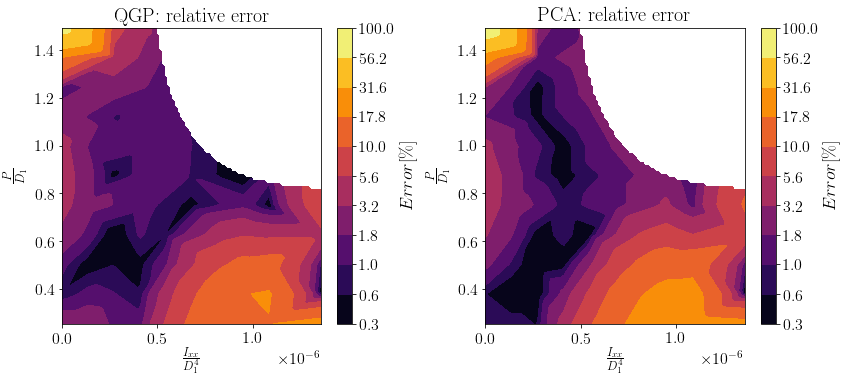

Saving figure!


(<Figure size 864x432 with 4 Axes>, <Figure size 864x432 with 2 Axes>)

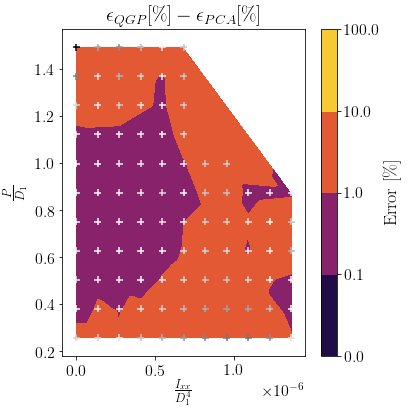

In [21]:
test_E_mean.plot_verification_countour(input_dictionary, xbounds = [0, max(X1), min(X2), max(X2)],
                            CMAP = 'inferno', xlabel = '$\\frac{I_{xx}}{D_1^4}$', suptitle = None, 
                      ylabel = '$\\frac{P}{D_1}$', zlabel = '$Error[\%]$', #,
                    #savepath1 = '/home/gawel/thesis/appendix_f/figures/'+ 'QGP_Eabs_error_verification.pdf', 
                                       idx_class = (idx_not_classified[1],idx_not_classified[0]), 
                                      bar_format = '%.1f',
                                     savepath1 = 'Figures/15_QGP_vs_PCA.pdf')  
                              # + 'QGP_Pcrit_error_verification.pdf')

[ 13.89   3.74  46.44 100.   100.    30.06  13.37   3.1   34.64   9.48
   0.6   12.97   2.15 100.     6.52  63.49   7.61   1.71  50.92   1.8
   8.27   3.05  10.65   6.19 100.    23.84   7.14   3.26  24.3    1.14
   3.93   5.86  19.66   5.99  74.43   5.41  18.76   2.58  18.88 100.
 100.    16.25  19.58   3.97  10.4  100.    10.06   4.49 100.    12.43
  52.77   3.24   6.19   8.54 100.    49.66  49.87   3.25  22.54 100.
  23.48  35.69 100.    17.57   1.47 100.     4.66  43.36  52.09  18.7
 100.    14.74 100.    35.34  15.38 100.   100.    24.15   4.46  30.9
  11.21  14.39  11.87   6.24  13.35   2.21   7.88 100.    13.47  16.41
  56.63   3.48 100.     2.05  44.37 100.    18.66  32.82]
error capped to 100%
Saving figure!


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:254: RuntimeWarning:invalid value encountered in greater
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:255: RuntimeWarning:invalid value encountered in less
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'rasterized'


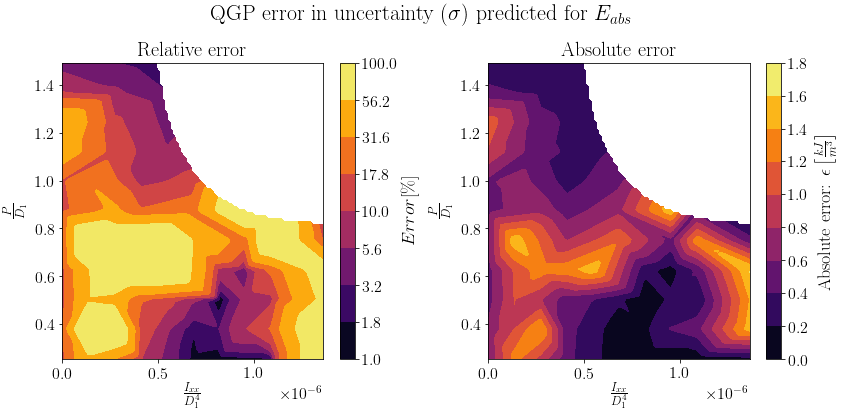

In [524]:
test_E_var.plot_error_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                         suptitle = 'QGP error in uncertainty ($\sigma$) predicted for $E_{abs}$',
                        idx_class= (idx_not_classified[1],idx_not_classified[0]), vmax = 100., variance_case = True, 
                        levels = np.logspace(0,2, 9 ), 
                        zlabel2 = 'Absolute error: $\epsilon\\left[\\frac{kJ}{m^3}\\right]$',

                    savepath = '/home/gawel/thesis/appendix_f/figures/' + 'QGP_Eabs_uncertainty_error.pdf')
                   
                        #savepath2 = '/home/gawel/thesis/chapter_4/figures/'  
                        #       + 'QGP_Pcrit_error_verification.pdf')
                              

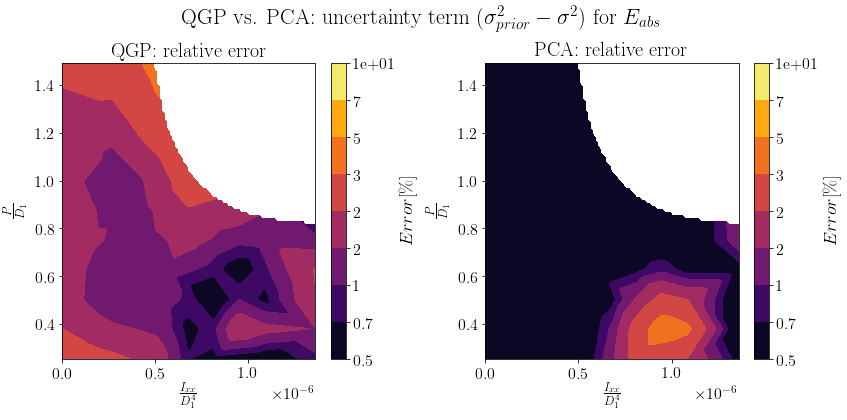

(<Figure size 864x432 with 4 Axes>, <Figure size 864x432 with 2 Axes>)

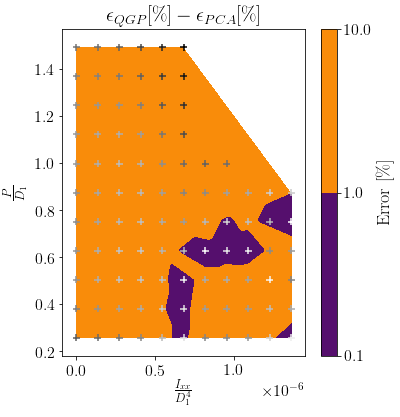

In [519]:
test_E_var.plot_verification_countour(xbounds = [0, max(X1), min(X2), max(X2)],
                            CMAP = 'inferno', xlabel = '$\\frac{I_{xx}}{D_1^4}$', 
                    suptitle = 'QGP vs. PCA: uncertainty term ($\sigma^2_{prior} -\sigma^2$) for $E_{abs}$', 
                      ylabel = '$\\frac{P}{D_1}$', zlabel = '$Error[\%]$',#, 
                    #savepath1 = '/home/gawel/thesis/appendix_f/figures/'+ 'QGP_Eabs_var_error_verification.pdf',
                                      idx_class = (idx_not_classified[1],idx_not_classified[0]),
                                     levels = np.logspace(-0.3, 1, 9),
                                      bar_format = '%1.1g', variance_case = True)


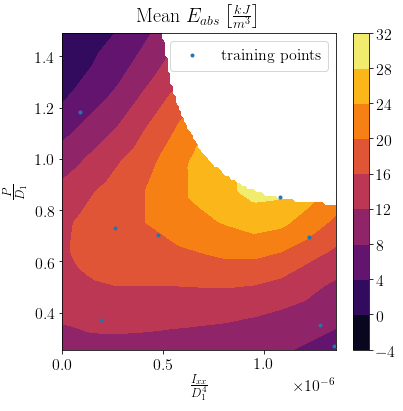

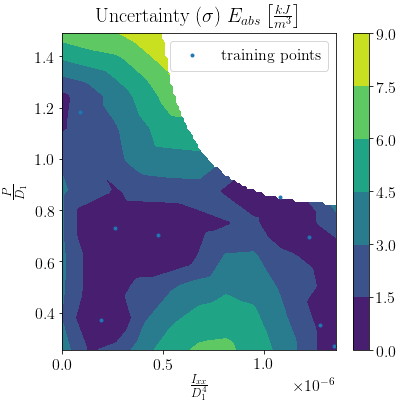

In [67]:
qgp_mean = test_E_mean._QGP_predict
points_mean = test_E_mean._xqgp

qgp_std = test_E_var._QGP_predict
points_std = test_E_var._xqgp 

combined_qgp_plot(qgp_mean, points_mean, qgp_std, points_std,
                  title = '$E_{abs}\\left[\\frac{kJ}{m^3}\\right]$', 
                  #savepath = '/home/gawel/thesis/chapter_4/figures/'  + 'E_QGP_2d.pdf',
                 Xtr = X[test_set], 
                split_plots = True, 
                 savepath = '/home/gawel/presentation_figs/PNGs/E-QGP', 
                 )

# Objective function


In [72]:
xbounds = [0, max(X1), min(X2), max(X2)]
grid_x, grid_y = np.mgrid[xbounds[0]:xbounds[1]:100j,
                          xbounds[2]:xbounds[3]:100j]

x, y = np.meshgrid(np.linspace(0, max(Ix), 100), np.linspace(min(PD), max(PD), 100))
Xnew = np.vstack((x.ravel(), y.ravel())).T
Xnew_scaled=scaler.transform(Xnew) 


mean_Pcrit_GPfull, Cov = m.predict(Xnew_scaled, full_cov=False)
mean_E_GPfull, cov= m_e.predict(Xnew_scaled, full_cov=False)

In [73]:
qgp_mean_E = test_E_mean._QGP_predict
points_mean_E = test_E_mean._xqgp

qgp_mean_P = test_8x8_1._QGP_predict
points_mean_P = test_8x8_1._xqgp

 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/numpy/ma/core.py:2788: ComplexWarning:Casting complex values to real discards the imaginary part


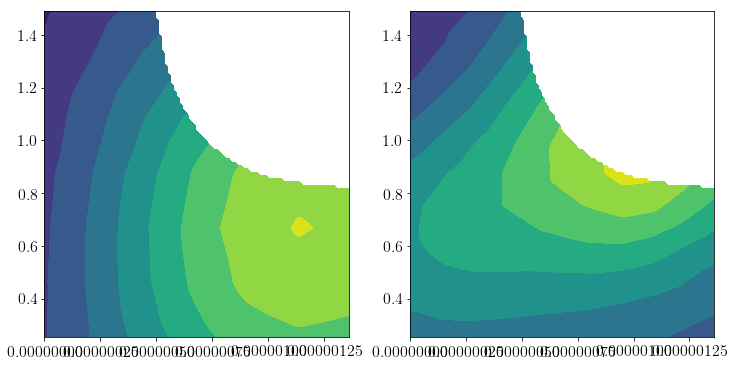

In [74]:
xbounds = [0, max(X1), min(X2), max(X2)]
xd, yd = np.mgrid[xbounds[0]:xbounds[1]:100j, xbounds[2]:xbounds[3]:100j]
grid_zE = griddata(points_mean_E ,qgp_mean_E , (xd, yd) , method='linear')
grid_zE[(idx_not_classified[1],idx_not_classified[0])] = np.nan

grid_zP = griddata(points_mean_P ,qgp_mean_P , (xd, yd) , method='linear')
grid_zP[(idx_not_classified[1],idx_not_classified[0])] = np.nan

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.contourf(xd, yd, grid_zP)

plt.subplot(1, 2, 2)
plt.contourf(xd, yd, grid_zE)

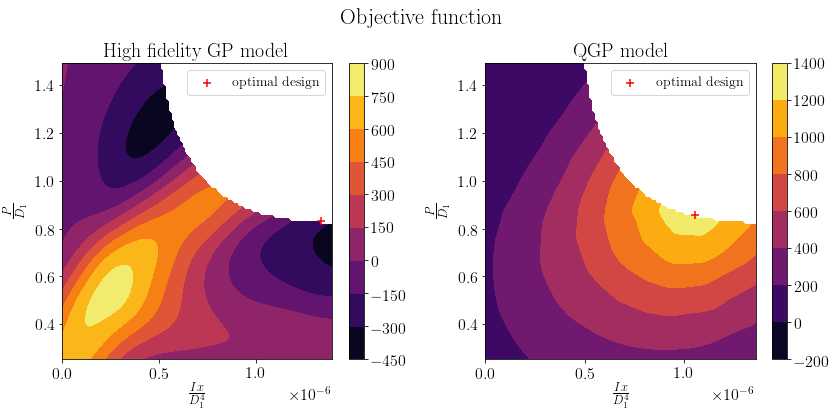

In [75]:
fig = plt.figure(figsize = (12, 6))


plt.subplot(1, 2,1)

objective_hifi = mean_Pcrit_GPfull*mean_E_GPfull

objective_hifi =objective_hifi.reshape(x.shape)
objective_hifi[idx_not_classified] = np.nan

plt.contourf(x, y, objective_hifi, cmap = 'inferno')
plt.colorbar()
ind = np.unravel_index(np.argmax(objective_hifi, axis=None), objective_hifi.shape)
plt.scatter(x[ind],y[ind], marker = '+', s = 60,c = 'r', label = 'optimal design')
plt.legend(fontsize = 14)
plt.ticklabel_format(style='sci', axis='x',  scilimits=(-1,0))
plt.xlabel(r'$\frac{Ix}{D_1^4}$') 
plt.ylabel(r'$\frac{P}{D_1}$')
plt.title('High fidelity GP model', size = 20)




plt.subplot(1, 2,2)


objective_QGP = grid_zP * grid_zE 
#objective_QGP[] = np.nan
plt.contourf(xd, yd, objective_QGP, cmap = 'inferno')
plt.colorbar()
plt.xlabel(r'$\frac{Ix}{D_1^4}$') 
plt.ylabel(r'$\frac{P}{D_1}$')
plt.title('QGP model', size = 20)
plt.ticklabel_format(style='sci', axis='x', scilimits=(-1,0))

indq = np.unravel_index(np.argmax(np.nan_to_num(objective_QGP) , axis=None), objective_QGP.shape)
plt.scatter(xd[indq],yd[indq], marker = '+', s = 60,c = 'r', label = 'optimal design')
plt.legend(fontsize = 14)
plt.tight_layout()

plt.subplots_adjust(top=0.85)     # Add space at top
plt.suptitle('Objective function', y= 0.98, size = 22)

#fig.savefig('/home/gawel/thesis/chapter_4/figures/objective_function.pdf')
#fig.savefig('/home/gawel/presentation_figs/PNGs/objective_function.png', dpi = 400)

In [76]:
ind

(46, 95)

In [77]:
print('hifi GP')
print(x[ind],y[ind])
print(mean_Pcrit_GPfull.reshape(x.shape)[ind], mean_E_GPfull.reshape(x.shape)[ind])


print('QGP:')
print(xd[indq],yd[indq])
print(grid_zP[indq],grid_zE[indq])




hifi GP
1.3368833353871615e-06 0.8300654902863842
-9.261716882186569 29.155481281734822
QGP:
1.0577110620591065e-06 0.8550494143603564
(45.87742205582552+0j) (28.449239267771592+0j)


(100, 100)

In [331]:
np.unravel_index(np.argmax(objective_hifi, axis=None), objective_hifi.shape)

(46, 95)

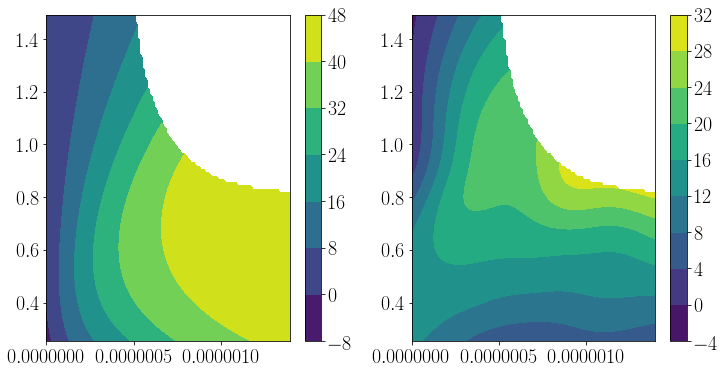

In [332]:
mean_Pcrit_GPfull.reshape(x.shape)[idx_not_classified] = np.nan
mean_E_GPfull.reshape(x.shape)[idx_not_classified] = np.nan

plt.figure(figsize = (12, 6))
plt.subplot(1,  2, 1)
plt.contourf(x, y, mean_Pcrit_GPfull.reshape(x.shape))
plt.colorbar()

plt.subplot(1,  2, 2)
plt.contourf(x, y, mean_E_GPfull.reshape(x.shape))
plt.colorbar()
plt.show()

plt.show()

In [333]:
mean_Pcrit_GPfull.shape

(10000, 1)

In [334]:
mean_E_GPfull.shape

(10000, 1)

In [ ]:
analysis_folder = 'DOE_Single_Astromat_1St_1ParamFirst_Imperfect-64-Ix'
dir_path = os.path.dirname('/home/gawel/FOR_MIGUEL/') 
#dir_path = os.path.dirname('FOR_MIGUEL/') 


E1 = Analyze(dir_path)

E1.load_DoE('DOE_Single_Astromat_1St_1ParamFirst_Imperfect-64-Ix')
E1.load_input('DOE_Single_Astromat_1St_1ParamFirst_Imperfect-64-Ix')
E1.load_postproc('DOE_Single_Astromat_1St_1ParamFirst_Imperfect_EF-64-Ix')

E1.derive_results()

In [246]:
(1.4e-6)**0.25


0.03439790628250393

In [247]:
(1.e-8)**0.25

0.01

# Uncertainty of the 8-point model

 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:overflow encountered in multiply
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:overflow encountered in square
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:551: RuntimeWarning:invalid value encountered in multiply
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:overflow encountered in multiply
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:invalid value encountered in subtract
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:554: RuntimeWarning:overflow encountered in squa

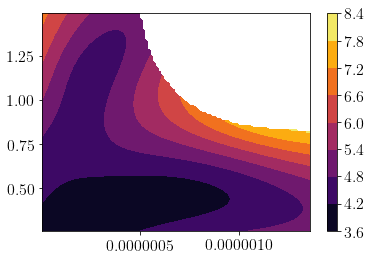

In [28]:
x, y = np.meshgrid(np.linspace(min(X1), max(X1), 100), np.linspace(min(X2), max(X2), 100))

n_sample_systems = 100
Means_array = []

for i in range(n_sample_systems):
    np.random.seed(i)
    test_set =  np.random.choice(len(X_scaled), 8)
    np.random.seed(i)
    m8_e_test = GPy.models.GPRegression(X_scaled[test_set], Eabs[test_set, None], GPy.kern.Matern52(2)) # can be also on residual
    m8_e_test.optimize()
    
    
    mean, Cov = m8_e_test.predict(Xnew_scaled, full_cov=False) 
    mean_mat = mean.reshape(x.shape)
    mean_mat[idx_not_classified] = np.nan
    Means_array.append(mean_mat)
    '''
    plot_GP_2d(X[test_set], Xnew_scaled, m8_e_test, x, y, idx_class = idx_not_classified,
                xlab  = r'$\frac{Ix}{D_1^4}$', 
                ylab = r'$\frac{P}{D_1}$', 
                suptitle = '$E_{abs}$: reduced classical GP model, test:' +str(i) )
               #,savepath = '/home/gawel/thesis/chapter_4/figures/'  + 'Eabs_8pts-classical_GP.pdf')
    plt.show()
    '''
    
stats = np.array(Means_array)
stds_E = np.std(stats, axis = 0)


plt.subplot(1,1,1)
plt.contourf(x, y,stds_E  , cmap = 'inferno', label = "STD in estimation between prediction of 5 moels with random")
plt.colorbar()
#plt.plot(X[:,0],X[:,1],'.', markersize = 8, label = 'training points'), #plt.axis("square")


In [55]:
mean_true, Cov = m.predict(Xnew_scaled, full_cov=False) 
mean_true_E, Cov = m_e.predict(Xnew_scaled, full_cov=False) 

Text(0.5, 0.98, 'Standard deviation of mean values predicted with 100 random reduced GP models')

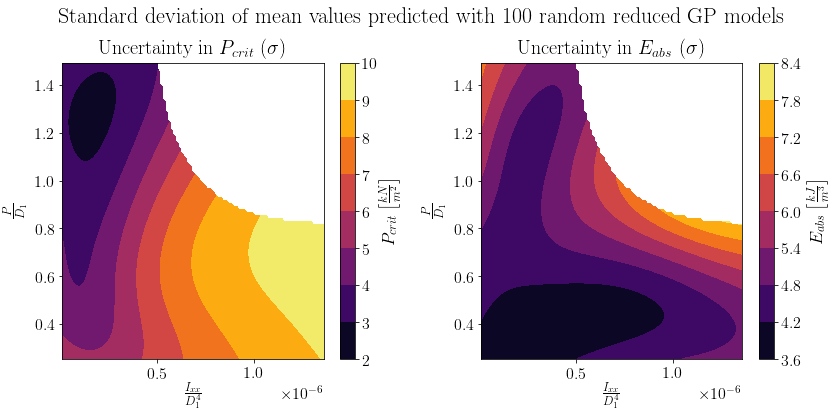

In [32]:
stats = np.array(Means_array)
stds = np.std(stats, axis = 0)

fig = plt.figure(figsize = (12, 6))

xlab = '$\\frac{I_{xx}}{D^4_1}$'
ylab = '$\\frac{P}{D_1}$'


plt.subplot(1,2,1)
plt.contourf(x, y,stds_Pcrit  , cmap = 'inferno', label = "STD in estimation between prediction of 100 moels with random")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel(ylab, size = 18)
plt.xlabel(xlab, size =18)
#plt.legend(prop={'size': 14})
plt.title("Uncertainty in $P_{crit}$ ($\sigma$)", size = 20)
plt.colorbar(label = '$P_{crit}\\left[\\frac{kN}{m^2}\\right]$')


plt.subplot(1,2,2)
plt.contourf(x, y,stds_E  , cmap = 'inferno', label = "STD in estimation between prediction of 100 moels with random")


plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel(ylab, size = 18)
plt.xlabel(xlab, size =18)
#plt.legend(prop={'size': 14})
plt.title("Uncertainty in $E_{abs}$ ($\sigma$)", size = 20)

clb = plt.colorbar()
clb.set_label('$E_{abs}\\left[\\frac{kJ}{m^3}\\right]$', labelpad=9)

plt.tight_layout()
plt.subplots_adjust( top=0.85)
#fig.subplots_adjust( )
fig.suptitle('Standard deviation of mean values predicted with 100 random reduced GP models', y = 0.98, size = 22)

#plt.plot(X[:,0],X[:,1],'.', markersize = 8, label = 'training points'), #plt.axis("square")
#fig.savefig('/home/gawel/thesis/discussion-2/figures/training-points-sensitivity.pdf')

 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning:invalid value encountered in greater
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning:invalid value encountered in less
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning:invalid value encountered in greater
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning:invalid value encountered in less


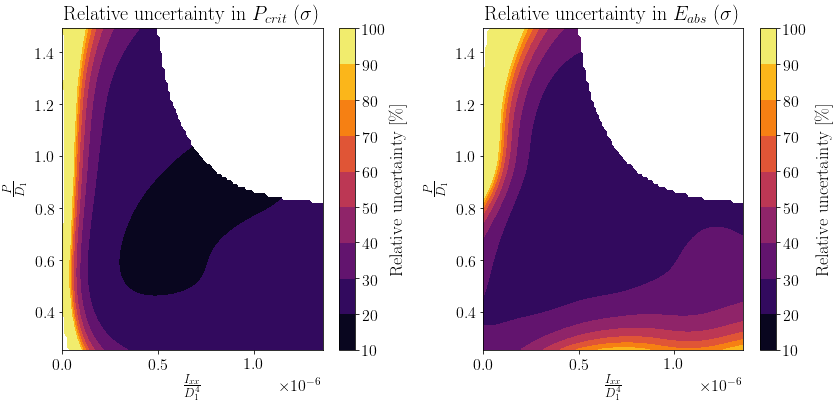

In [74]:
stats = np.array(Means_array)
stds_rel = np.std(stats, axis = 0)

fig = plt.figure(figsize = (12, 6))

xlab = '$\\frac{I_{xx}}{D^4_1}$'
ylab = '$\\frac{P}{D_1}$'

std_rel_p = 100.*stds_Pcrit/mean_true.reshape(x.shape)
std_rel_p[np.where(std_rel_p>100.)] = 100.
std_rel_p[np.where(std_rel_p<0.)] = np.nan



std_rel_E = 100.*stds_E/mean_true_E.reshape(x.shape)
std_rel_E[np.where(std_rel_E>100.)] = 100.
std_rel_E[np.where(std_rel_E<0.)] = np.nan

plt.subplot(1,2,1)
plt.contourf(x, y, std_rel_p , cmap = 'inferno', 
             label = "STD in estimation between prediction of 100 moels with random",
            levels = np.linspace(10, 100, 10)
            )#, norm = LogNorm(), 
             #levels = np.logspace(0, 2, 12))
            
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel(ylab, size = 18)
plt.xlabel(xlab, size =18)
#plt.legend(prop={'size': 14})
plt.title("Relative uncertainty in $P_{crit}$ ($\sigma$)", size = 20)
plt.colorbar(label = 'Relative uncertainty $[\%]$')


plt.subplot(1,2,2)
plt.contourf(x, y, std_rel_E  , cmap = 'inferno', 
             label = "STD in estimation between prediction of 100 moels with random", levels = np.linspace(10, 100, 10))


plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel(ylab, size = 18)
plt.xlabel(xlab, size =18)
#plt.legend(prop={'size': 14})
plt.title("Relative uncertainty in $E_{abs}$ ($\sigma$)", size = 20)

clb = plt.colorbar()
clb.set_label(label = 'Relative uncertainty $[\%]$', labelpad=9)

plt.tight_layout()
#plt.subplots_adjust( top=0.85)
#fig.subplots_adjust( )
#fig.suptitle('Relative deviation of mean values predicted with 100 random reduced GP models', y = 0.98, size = 22)

#plt.plot(X[:,0],X[:,1],'.', markersize = 8, label = 'training points'), #plt.axis("square")
fig.savefig('/home/gawel/thesis/discussion-2/figures/training-points-sensitivity-relative.pdf')

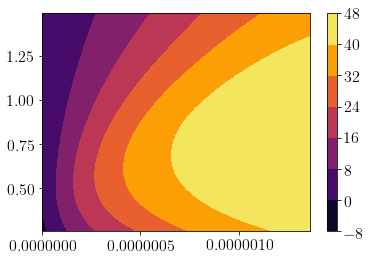

In [56]:
plt.contourf(x, y, mean_true.reshape(x.shape)  , cmap = 'inferno', label = "STD in estimation between prediction of 100 moels with random")

plt.colorbar()

In [50]:
np.min(mean_true)

-18.614818659323717

 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label'


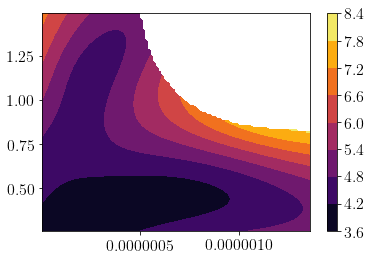

In [47]:
plt.contourf(x, y, stds_E  , cmap = 'inferno', label = "STD in estimation between prediction of 100 moels with random")
plt.colorbar()

# Alternative sampling

Text(0.5, 0, '$log_{10}(\\frac{I_{xx}}{D^4_1})$')

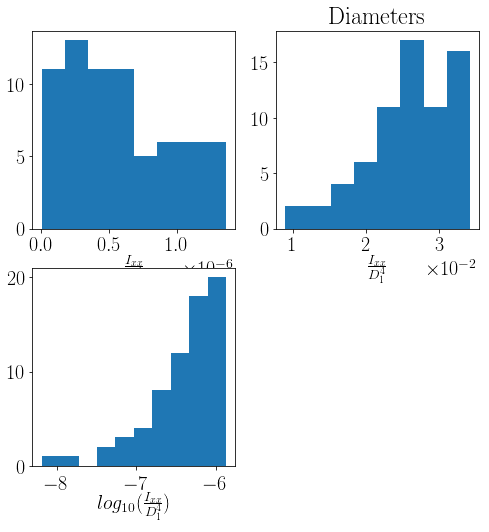

In [268]:
Ix = E_dict['{Ix}{D_1^4}']

plt.figure( figsize  = (8, 8))

plt.subplot(2, 2, 1)
plt.hist(E_dict['{Ix}{D_1^4}'], bins = 'auto')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('$\\frac{I_{xx}}{D^4_1}$')

plt.subplot(2, 2, 2)


plt.hist(Ix**0.25, bins = 'auto')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('$\\frac{I_{xx}}{D^4_1}$')
plt.title('Diameters')


Ixmax = 1.4e-6
Ixmin = 2.5e-11

plt.subplot(2, 2,3)

plt.hist(np.log10(Ix), bins = 'auto')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('$log_{10}(\\frac{I_{xx}}{D^4_1})$')






In [270]:
Ixmin**0.25


0.00223606797749979

In [263]:
np.log10(Ixmin)

-10.602059991327963

In [ ]:


plt.hist(Ix**0.25, bins = 'auto')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('$\\frac{I_{xx}}{D^4_1}$')

# DRAFTS

## Postprocessing QGP 8x8

In [71]:
import os
Res_dicts = []
Input_dict = []
idx_list = []


f = open(os.path.expanduser("~/qgpr/serial_experiment_2d/PD-Ix-100_8x8-49/compiled_HHL_circuit_params.pickle"),'rb')
Input_dict = pickle.load(f)
f.close()

from os import listdir
from os.path import isfile, join

res_path = os.path.expanduser("~/qgpr/serial_experiment_2d/PD-Ix-100_8x8-49/results/")

for file in listdir(res_path):
    idx_list.append(int(file[6:-7]))
    f = open(os.path.join(res_path, file), 'rb')
    Res_dicts.append(pickle.load(f))
    f.close()


In [53]:
res_path = os.path.expanduser("~/qgpr/serial_experiment_2d/PD-Ix-100_8x8-49/results/")
os.joinpath()

In [57]:
Res_dicts

[{'qgp_result_stv': (11.550218669826954+0j),
  'classical_result': 4.6603702767878445,
  'error%_stv': 147.83907680803276,
  'input_matrix': array([[753.90888433, 417.49192768, 481.89410152, 457.34848505,
          554.81752873, 725.24231785, 377.42845525, 448.99476633],
         [417.49192768, 753.90888433, 550.84196007, 641.37742086,
          637.88016961, 516.66338022, 707.57354159, 625.62567526],
         [481.89410152, 550.84196007, 753.90888433, 726.16604714,
          462.86734439, 532.94012333, 624.6140976 , 384.24216418],
         [457.34848505, 641.37742086, 726.16604714, 753.90888433,
          517.93461691, 530.75289902, 705.9107264 , 451.26603042],
         [554.81752873, 637.88016961, 462.86734439, 517.93461691,
          753.90888433, 646.54196941, 528.79591247, 721.38075461],
         [725.24231785, 516.66338022, 532.94012333, 530.75289902,
          646.54196941, 753.90888433, 463.24058142, 542.21241924],
         [377.42845525, 707.57354159, 624.6140976 , 705.9107264

In [58]:
Input_dict

{'algorithm': {'name': 'HHL',
  'truncate_powerdim': False,
  'truncate_hermitian': False,
  'orig_size': 8},
 'eigs': {'name': 'EigsQPE',
  'num_ancillae': 8,
  'num_time_slices': 20,
  'expansion_mode': 'suzuki',
  'expansion_order': 2,
  'negative_evals': False},
 'iqft': {'name': 'STANDARD', 'num_qubits': 8},
 'qft': {'name': 'STANDARD'},
 'initial_state': {'name': 'CUSTOM', 'state_vector': array([[0.22446394],
         [0.41986206],
         [0.13541415],
         [0.27629458],
         [0.4812187 ],
         [0.33530698],
         [0.29569888],
         [0.49720828]]), 'num_qubits': 3},
 'reciprocal': {'name': 'Lookup',
  'negative_evals': False,
  'evo_time': 0.0011090746743631513,
  'lambda_min': 4.2200513398126365},
 'f1': 4.2200513398126365}

In [135]:
QGP_pcrit = []
QGP_error = []
xqgp = []
classical_res = []
for i in range(len(Res_dicts)):
    QGP_pcrit.append(Res_dicts[i]['qgp_result_stv'])
    QGP_error.append(Res_dicts[i]['error%_stv'])
    xqgp.append(Xnew_test[idx_list[i]])
    classical_res.append(Res_dicts[i]['classical_result'])
    #print(Xnew_test[idx_list[i]])
    #print(i, idx_list[i])
                   
xqgp = np.array(xqgp)
QGP_pcrit = np.real(np.array(QGP_pcrit))
QGP_error = np.array(QGP_error)
classical_res = np.array(classical_res)

In [136]:
xqgp

array([[0.00000000e+00, 2.55435237e-01],
       [6.79957111e-07, 8.73787357e-01],
       [1.35991422e-06, 4.61552610e-01],
       [4.53304741e-07, 4.61552610e-01],
       [2.26652370e-07, 8.73787357e-01],
       [9.06609482e-07, 6.67669984e-01],
       [0.00000000e+00, 1.07990473e+00],
       [2.26652370e-07, 1.07990473e+00],
       [2.26652370e-07, 4.61552610e-01],
       [4.53304741e-07, 6.67669984e-01],
       [4.53304741e-07, 1.07990473e+00],
       [6.79957111e-07, 6.67669984e-01],
       [0.00000000e+00, 4.61552610e-01],
       [1.35991422e-06, 2.55435237e-01],
       [1.35991422e-06, 8.73787357e-01],
       [9.06609482e-07, 8.73787357e-01],
       [6.79957111e-07, 2.55435237e-01],
       [9.06609482e-07, 2.55435237e-01],
       [1.13326185e-06, 8.73787357e-01],
       [2.26652370e-07, 6.67669984e-01],
       [1.13326185e-06, 4.61552610e-01],
       [1.35991422e-06, 6.67669984e-01],
       [2.26652370e-07, 2.55435237e-01],
       [9.06609482e-07, 4.61552610e-01],
       [1.133261

In [137]:
idx_list

[0,
 24,
 13,
 9,
 22,
 18,
 28,
 29,
 8,
 16,
 30,
 17,
 7,
 6,
 27,
 25,
 3,
 4,
 26,
 15,
 12,
 20,
 1,
 11,
 5,
 21,
 23,
 14,
 10,
 19,
 2]

In [138]:
Xnew_test

array([[0.00000000e+00, 2.55435237e-01],
       [2.26652370e-07, 2.55435237e-01],
       [4.53304741e-07, 2.55435237e-01],
       [6.79957111e-07, 2.55435237e-01],
       [9.06609482e-07, 2.55435237e-01],
       [1.13326185e-06, 2.55435237e-01],
       [1.35991422e-06, 2.55435237e-01],
       [0.00000000e+00, 4.61552610e-01],
       [2.26652370e-07, 4.61552610e-01],
       [4.53304741e-07, 4.61552610e-01],
       [6.79957111e-07, 4.61552610e-01],
       [9.06609482e-07, 4.61552610e-01],
       [1.13326185e-06, 4.61552610e-01],
       [1.35991422e-06, 4.61552610e-01],
       [0.00000000e+00, 6.67669984e-01],
       [2.26652370e-07, 6.67669984e-01],
       [4.53304741e-07, 6.67669984e-01],
       [6.79957111e-07, 6.67669984e-01],
       [9.06609482e-07, 6.67669984e-01],
       [1.13326185e-06, 6.67669984e-01],
       [1.35991422e-06, 6.67669984e-01],
       [0.00000000e+00, 8.73787357e-01],
       [2.26652370e-07, 8.73787357e-01],
       [4.53304741e-07, 8.73787357e-01],
       [6.799571

In [139]:
xqgp[:,0]

array([0.00000000e+00, 6.79957111e-07, 1.35991422e-06, 4.53304741e-07,
       2.26652370e-07, 9.06609482e-07, 0.00000000e+00, 2.26652370e-07,
       2.26652370e-07, 4.53304741e-07, 4.53304741e-07, 6.79957111e-07,
       0.00000000e+00, 1.35991422e-06, 1.35991422e-06, 9.06609482e-07,
       6.79957111e-07, 9.06609482e-07, 1.13326185e-06, 2.26652370e-07,
       1.13326185e-06, 1.35991422e-06, 2.26652370e-07, 9.06609482e-07,
       1.13326185e-06, 0.00000000e+00, 4.53304741e-07, 0.00000000e+00,
       6.79957111e-07, 1.13326185e-06, 4.53304741e-07])

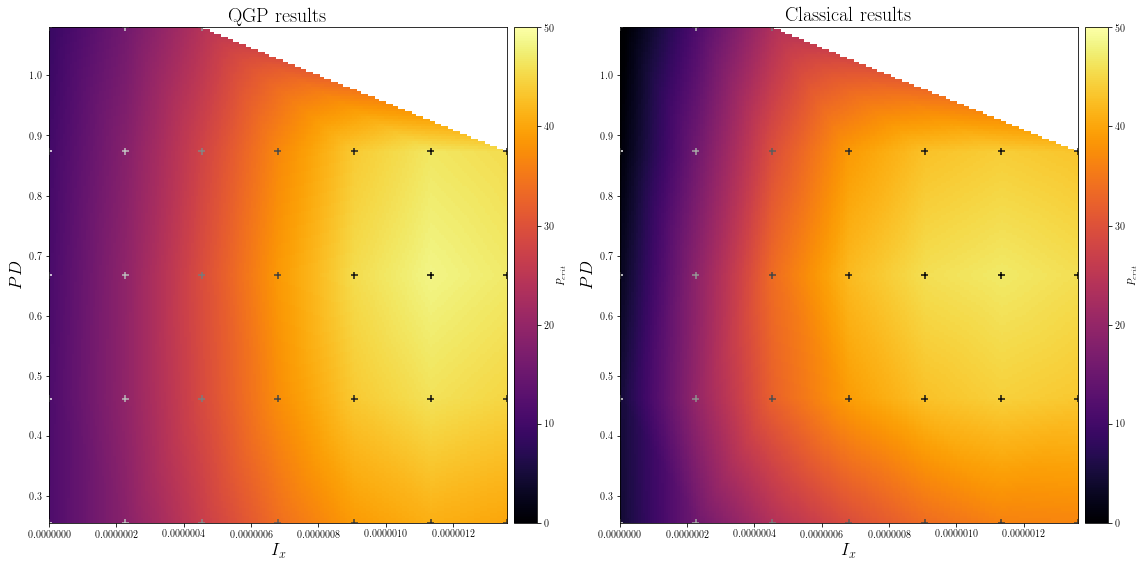

In [144]:
grid_x, grid_y = np.mgrid[min(xqgp[:, 0]):max(xqgp[:, 0]):200j, min(xqgp[:, 1]):max(xqgp[:, 1]):200j]
points = xqgp #np.array([x, y]).T
z = QGP_pcrit
title = None
xlabel = '$I_x$'
ylabel = '$PD$'
zlabel = '$P_{crit}$'

grid_z = griddata(points, z, (grid_x, grid_y), method='linear')

fig = plt.figure(figsize = (16,8 ))
#ax = plt.gca()
ax = plt.subplot(1, 2, 1)
ax.scatter(xqgp[:, 0], xqgp[:, 1], marker = '+', c= 100-z, s = 50, cmap='gray')
if title is None:
    ax.set_title('QGP results', size = 20)

ax.set_xlabel(xlabel, size = 18)
ax.set_ylabel(ylabel, size = 18)
a = (max(xqgp[:, 0])-min(xqgp[:, 0]))/(max(xqgp[:, 1])-min(xqgp[:, 1]))       
im = ax.imshow(grid_z.T, cmap = 'inferno', extent=(min(xqgp[:, 0]), max(xqgp[:, 0]),
                                                   min(xqgp[:, 1]), max(xqgp[:, 1])),
                                           aspect = 'auto',  origin='lower', 
              vmin = 0, vmax = 50)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label= zlabel)
plt.tight_layout()




ax2 = plt.subplot(1, 2, 2)
z = classical_res
title = None
xlabel = '$I_x$'
ylabel = '$PD$'
zlabel = '$P_{crit}$'

grid_z = griddata(points, z, (grid_x, grid_y), method='linear')

#ax = plt.gca()
ax2.scatter(xqgp[:, 0], xqgp[:, 1], marker = '+', c= 100-z, s = 50, cmap='gray')
title = None
if title is None:
    ax2.set_title('Classical results', size = 20)

ax2.set_xlabel(xlabel, size = 18)
ax2.set_ylabel(ylabel, size = 18)
a = (max(xqgp[:, 0])-min(xqgp[:, 0]))/(max(xqgp[:, 1])-min(xqgp[:, 1]))       
im = ax2.imshow(grid_z.T, cmap = 'inferno', extent=(min(xqgp[:, 0]), max(xqgp[:, 0]),
                                                   min(xqgp[:, 1]), max(xqgp[:, 1])),
                                           aspect = 'auto',  origin='lower',
                                           vmin = 0, vmax = 50)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax, label= zlabel)
plt.tight_layout()

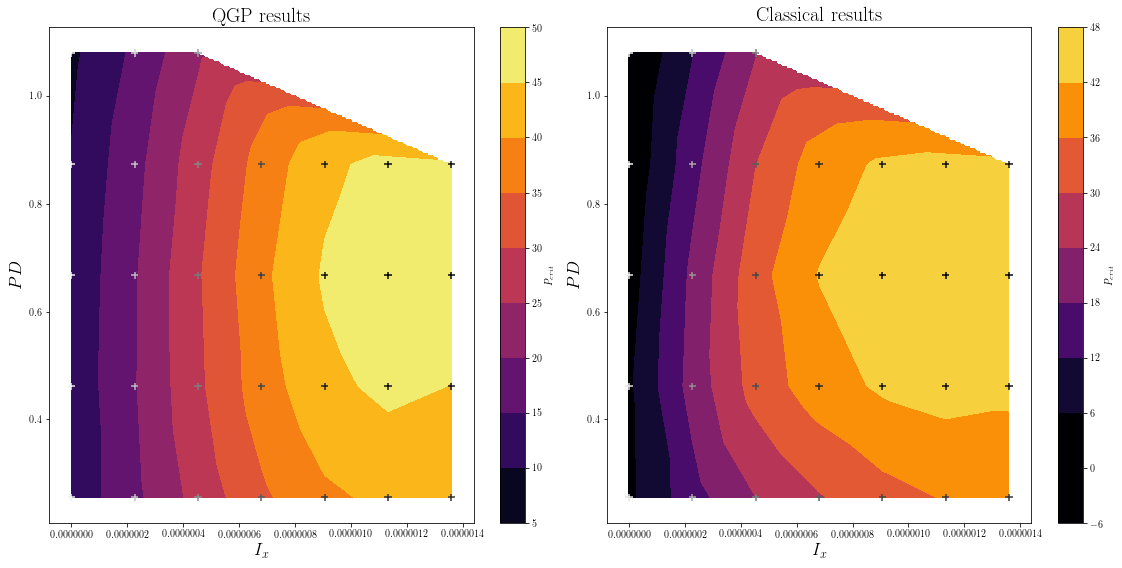

In [216]:
import seaborn as sns

from matplotlib.colors import ListedColormap

#my_cmap = sns.light_palette("RdYlGn", as_cmap=True)
#my_cmap = sns.light_palette("RdYlGn", as_cmap = True)


#['RdYlBu_r', 'RdYlGn_r','jet', 'rainbow', 'Spectral_r', 'inferno', 'CMRmap', 'nipy_spectral', 'gnuplot2']:
CMAP = 'RdYlBu_r'#ListedColormap(sns.color_palette("BuYlRd",256)) #'plasma'
#CMAP = 'Spectral_r'
CMAP = 'inferno'



grid_x, grid_y = np.mgrid[min(xqgp[:, 0]):max(xqgp[:, 0]):200j, min(xqgp[:, 1]):max(xqgp[:, 1]):200j]
points = xqgp #np.array([x, y]).T
z = QGP_pcrit
title = None
xlabel = '$I_x$'
ylabel = '$PD$'
zlabel = '$P_{crit}$'

grid_z = griddata(points, z, (grid_x, grid_y), method='linear')

plt.figure(figsize = (16,8 ))
#ax = plt.gca()
plt.subplot(1, 2, 1)


plt.xlabel(xlabel, size = 18)
plt.ylabel(ylabel, size = 18)
a = (max(xqgp[:, 0])-min(xqgp[:, 0]))/(max(xqgp[:, 1])-min(xqgp[:, 1]))   

#.contourf(x, y,mean_mat  , cmap = 'inferno')
img0 = plt.contourf(grid_x, grid_y, grid_z, cmap = CMAP, 
                                         extent=(min(xqgp[:, 0]), max(xqgp[:, 0]),
                                            min(xqgp[:, 1]), max(xqgp[:, 1])), 
                                             vmin = 5, vmax = 50,
                                            origin='lower')

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(img0, label= zlabel)
plt.tight_layout()

plt.scatter(xqgp[:, 0], xqgp[:, 1], marker = '+', c= 100-z, s = 50, cmap='gray')
plt.title('QGP results', size = 20)



plt.subplot(1, 2, 2)
z = classical_res
title = None
xlabel = '$I_x$'
ylabel = '$PD$'
zlabel = '$P_{crit}$'

grid_z = griddata(points, z, (grid_x, grid_y), method='linear')

#ax = plt.gca()


plt.xlabel(xlabel, size = 18)
plt.ylabel(ylabel, size = 18)
a = (max(xqgp[:, 0])-min(xqgp[:, 0]))/(max(xqgp[:, 1])-min(xqgp[:, 1]))       
img = plt.contourf(grid_x, grid_y, grid_z, cmap = CMAP, extent=(min(xqgp[:, 0]), max(xqgp[:, 0]),
                                                   min(xqgp[:, 1]), max(xqgp[:, 1])),
                                            origin='lower',
                                         vmin = 5, vmax = 50)
#divider = make_axes_locatable()
#cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(img, label= zlabel)
plt.scatter(xqgp[:, 0], xqgp[:, 1], marker = '+', c= 100-z, s = 50, cmap='gray')
plt.title('Classical results', size = 20)


plt.tight_layout()





In [198]:
sns.color_palette

<function seaborn.palettes.color_palette(palette=None, n_colors=None, desat=None)>

In [150]:
(min(xqgp[:, 0]), max(xqgp[:, 0]),
                                            min(xqgp[:, 1]), max(xqgp[:, 1]))

(0.0, 1.3599142226474227e-06, 0.2554352365850249, 1.0799047310261056)

GP prediction with noise

Name : GP regression
Objective : 28.81349026686881
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |                  value  |  constraints  |  priors
  Mat52.variance           |      753.9088843306378  |      +ve      |        
  Mat52.lengthscale        |     2.8347316593522405  |      +ve      |        
  Gaussian_noise.variance  |  9.931010744479322e-32  |      +ve      |        


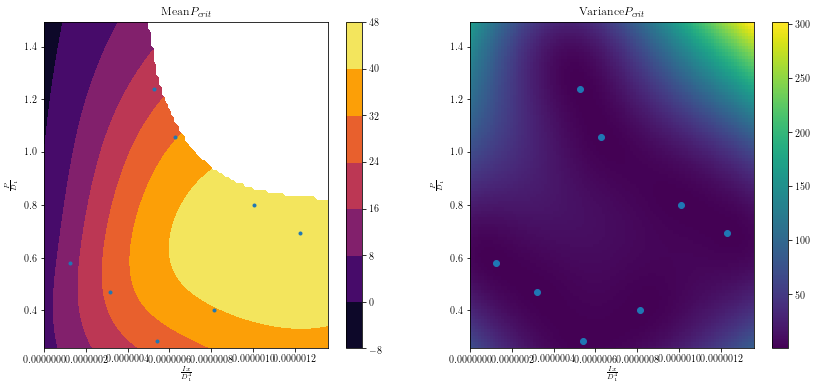

In [60]:
x, y = np.meshgrid(np.linspace(0, max(X1), 100), np.linspace(min(X2), max(X2), 100))

plot_GP_2d(X[:8], Xnew_scaled, m8, x, y, idx_class = idx_not_classified,
            xlab  = r'$\frac{Ix}{D_1^4}$', 
            ylab = r'$\frac{P}{D_1}$', 
            title = '$P_{crit}$' )

## Postprocessing QGP 16x16

In [218]:
import os
Res_dicts_16 = []
Input_dict_16 = []
idx_list_16 = []


#f = open(os.path.expanduser("~/qgpr/serial_experiment_2d/PD-Ix-100_8x8-49/compiled_HHL_circuit_params.pickle"),'rb')
#Input_dict = pickle.load(f)
#f.close()

from os import listdir
from os.path import isfile, join

res_path_16 = os.path.expanduser("~/qgpr/serial_experiment_2d/PD-Ix-100_16x16-49/results/")

for file in listdir(res_path_16):
    idx_list_16.append(int(file[6:-7]))
    f = open(os.path.join(res_path_16, file), 'rb')
    Res_dicts_16.append(pickle.load(f))
    f.close()
    


In [221]:
QGP_pcrit = []
QGP_error = []
xqgp = []
classical_res = []
for i in range(len(Res_dicts_16)):
    QGP_pcrit.append(Res_dicts_16[i]['qgp_result_stv'])
    QGP_error.append(Res_dicts_16[i]['error%_stv'])
    xqgp.append(Xnew_test[idx_list_16[i]])
    classical_res.append(Res_dicts_16[i]['classical_result'])
    #print(Xnew_test[idx_list[i]])
    #print(i, idx_list[i])
                   
xqgp = np.array(xqgp)
QGP_pcrit = np.real(np.array(QGP_pcrit))
QGP_error = np.array(QGP_error)
classical_res = np.array(classical_res)

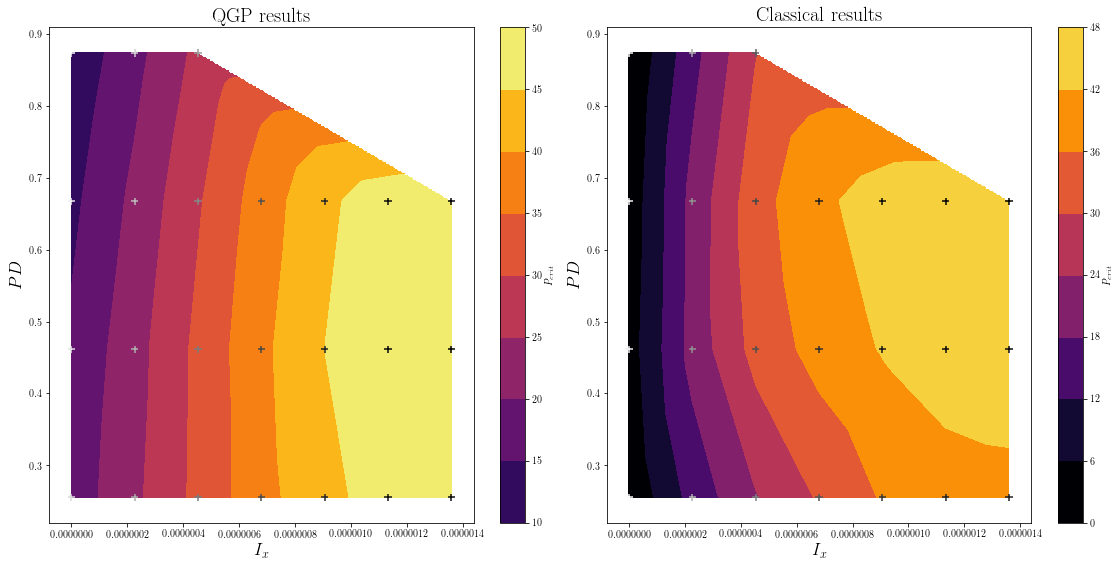

In [222]:
import seaborn as sns

from matplotlib.colors import ListedColormap

#my_cmap = sns.light_palette("RdYlGn", as_cmap=True)
#my_cmap = sns.light_palette("RdYlGn", as_cmap = True)


#['RdYlBu_r', 'RdYlGn_r','jet', 'rainbow', 'Spectral_r', 'inferno', 'CMRmap', 'nipy_spectral', 'gnuplot2']:
CMAP = 'RdYlBu_r'#ListedColormap(sns.color_palette("BuYlRd",256)) #'plasma'
#CMAP = 'Spectral_r'
CMAP = 'inferno'



grid_x, grid_y = np.mgrid[min(xqgp[:, 0]):max(xqgp[:, 0]):200j, min(xqgp[:, 1]):max(xqgp[:, 1]):200j]
points = xqgp #np.array([x, y]).T
z = QGP_pcrit
title = None
xlabel = '$I_x$'
ylabel = '$PD$'
zlabel = '$P_{crit}$'

grid_z = griddata(points, z, (grid_x, grid_y), method='linear')

plt.figure(figsize = (16,8 ))
#ax = plt.gca()
plt.subplot(1, 2, 1)


plt.xlabel(xlabel, size = 18)
plt.ylabel(ylabel, size = 18)
a = (max(xqgp[:, 0])-min(xqgp[:, 0]))/(max(xqgp[:, 1])-min(xqgp[:, 1]))   

#.contourf(x, y,mean_mat  , cmap = 'inferno')
img0 = plt.contourf(grid_x, grid_y, grid_z, cmap = CMAP, 
                                         extent=(min(xqgp[:, 0]), max(xqgp[:, 0]),
                                            min(xqgp[:, 1]), max(xqgp[:, 1])), 
                                             vmin = 5, vmax = 50,
                                            origin='lower')

#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(img0, label= zlabel)
plt.tight_layout()

plt.scatter(xqgp[:, 0], xqgp[:, 1], marker = '+', c= 100-z, s = 50, cmap='gray')
plt.title('QGP results', size = 20)



plt.subplot(1, 2, 2)
z = classical_res
title = None
xlabel = '$I_x$'
ylabel = '$PD$'
zlabel = '$P_{crit}$'

grid_z = griddata(points, z, (grid_x, grid_y), method='linear')


plt.xlabel(xlabel, size = 18)
plt.ylabel(ylabel, size = 18)
a = (max(xqgp[:, 0])-min(xqgp[:, 0]))/(max(xqgp[:, 1])-min(xqgp[:, 1]))       
img = plt.contourf(grid_x, grid_y, grid_z, cmap = CMAP, extent=(min(xqgp[:, 0]), max(xqgp[:, 0]),
                                                   min(xqgp[:, 1]), max(xqgp[:, 1])),
                                            origin='lower',
                                         vmin = 5, vmax = 50)
#divider = make_axes_locatable()
#cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(img, label= zlabel)
plt.scatter(xqgp[:, 0], xqgp[:, 1], marker = '+', c= 100-z, s = 50, cmap='gray')
plt.title('Classical results', size = 20)


plt.tight_layout()



